# Assignment 3:

# Model Interpretability



*   **Name: Apoorv Dhaygude**
*   **NUID: 002207325**

# ABSTRACT

The data analysts at BigMart have collected sales data of Fiscal Year 2013 for different products across multiple stores. The collected data includes some imporatant attributes of the product like fat content, weight, visibility etc.

# AIM OF ASSIGNMENT:

The goal was to construct a regression model, a classifier model and using H20 AutoML to determine the best model for the choosen dataset. After building these models SHAP Analysis should be done all those models. By doing this, SHAP values are obtained and then compared with other model interpretability models.

# VARIABLE DESCRIPTION:

Item_Identifier: Unique product ID

Item_Weight: Weight of product

Item_Fat_Content: Whether the product is low fat or not

Item_Visibility: The % of total display area of all products in a store allocated to the particular product

Item_Type: The category to which the product belongs

Item_MRP: Maximum Retail Price (list price) of the product

Outlet_Identifier: Unique store ID

Outlet_Establishment_Year: The year in which store was established

Outlet_Size: The size of the store in terms of ground area covered

Outlet_Location_Type: The type of city in which the store is located

Outlet_Type: Whether the outlet is just a grocery store or some sort of supermarket

Item_Outlet_Sales: Sales of the product in the particular store. This is the outcome variable to be predicted.

# Importing required Libraries and H20 Initialization

In [1]:
!pip install requests
!pip install tabulate
!pip install "colorama>=0.3.8"
!pip install future

In [2]:
!pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o

Looking in links: http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.2/265.2 MB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for h2o: filename=h2o-3.44.0.3-py2.py3-none-any.whl size=265293966 sha256=1d09bbc63c8df24d7d617567b3d9f41c13d5e87d752179719b9d6bc474a453e8
  Stored in directory: /root/.cache/pip/wheels/77/9a/1c/2da26f943fd46b57f3c20b54847b936b9152b831dc7447cf71
Successfully built h2o


In [4]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(context="notebook", palette="Spectral", style = 'darkgrid' ,font_scale = 1.5, color_codes=True)
import warnings
warnings.filterwarnings('ignore')
import os
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.compat import lzip
import statsmodels.stats.api as sms
from sklearn.model_selection import train_test_split as tts
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error
from yellowbrick.regressor import ResidualsPlot
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV

# Reading and Analyzing Dataset

In [6]:
data = pd.read_csv("https://github.com/apoorv1811/DataScience/raw/main/BigMart.csv")

In [7]:
data.head()

Item_Weight  Item_Fat_Content  Item_Visibility  Item_Type  Item_MRP  \
0     0.282525               0.0         0.048866   0.266667  0.927507   
1     0.081274               1.0         0.058705   0.933333  0.072068   
2     0.770765               0.0         0.051037   0.666667  0.468288   
3     0.871986               1.0         0.000000   0.400000  0.640093   
4     0.260494               0.0         0.000000   0.600000  0.095805   

   Outlet_Identifier  Outlet_Size  Outlet_Location_Type  Outlet_Type  \
0           1.000000          0.5                   0.0     0.333333   
1           0.333333          0.5                   1.0     0.666667   
2           1.000000          0.5                   0.0     0.333333   
3           0.000000          1.0                   1.0     0.000000   
4           0.111111          0.0                   1.0     0.333333   

   Item_Outlet_Sales  Outlet_Age  
0           0.283587    0.583333  
1           0.031419    1.000000  
2           0.158115    0.583333  
3           0.053555    0.541667  
4           0.073651    0.083333

In [8]:
data.shape

(8523, 11)

In [9]:
#taking the basic information of all the columns in the given dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Item_Weight           8523 non-null   float64
 1   Item_Fat_Content      8523 non-null   float64
 2   Item_Visibility       8523 non-null   float64
 3   Item_Type             8523 non-null   float64
 4   Item_MRP              8523 non-null   float64
 5   Outlet_Identifier     8523 non-null   float64
 6   Outlet_Size           8523 non-null   float64
 7   Outlet_Location_Type  8523 non-null   float64
 8   Outlet_Type           8523 non-null   float64
 9   Item_Outlet_Sales     8523 non-null   float64
 10  Outlet_Age            8523 non-null   float64
dtypes: float64(11)
memory usage: 732.6 KB


In [10]:
X=data.drop(['Item_Outlet_Sales'],axis=1)
y=data['Item_Outlet_Sales']

In [11]:
X_train,X_test,y_train,y_test=tts(X,y,test_size=0.2,random_state=42)

In [12]:
#Calculating VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_train.columns

# calculating VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(X_train.values, i)
                          for i in range(len(X_train.columns))]

print(vif_data)

                feature       VIF
0           Item_Weight  4.296885
1      Item_Fat_Content  1.551955
2       Item_Visibility  2.658212
3             Item_Type  3.781554
4              Item_MRP  3.887604
5     Outlet_Identifier  9.651824
6           Outlet_Size  6.008836
7  Outlet_Location_Type  8.734249
8           Outlet_Type  8.147712
9            Outlet_Age  3.611622


In [14]:
cols= ['Item_Weight','Item_Fat_Content', 'Item_Visibility','Item_Type','Item_MRP', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type','Outlet_Type','Outlet_Age']
model = sm.OLS(y_train,sm.add_constant(X_train[cols])).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:      Item_Outlet_Sales   R-squared:                       0.507
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     701.2
Date:                Thu, 14 Mar 2024   Prob (F-statistic):               0.00
Time:                        00:27:57   Log-Likelihood:                 6558.3
No. Observations:                6818   AIC:                        -1.309e+04
Df Residuals:                    6807   BIC:                        -1.302e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0155 

As seen from the OLS summary p-value for 'Item_Weight' ,'Item_Type' and 'Outlet_Age' is greater than 0.05. Dropping them will give us a model with all variables whose p-values are less than 0.05. The accuracy for this model is ~ 51%.

In [15]:
data=data.drop(['Item_Weight','Item_Type','Outlet_Age'],axis=1)

Text(0.5, 1.0, 'Variable Correlation')

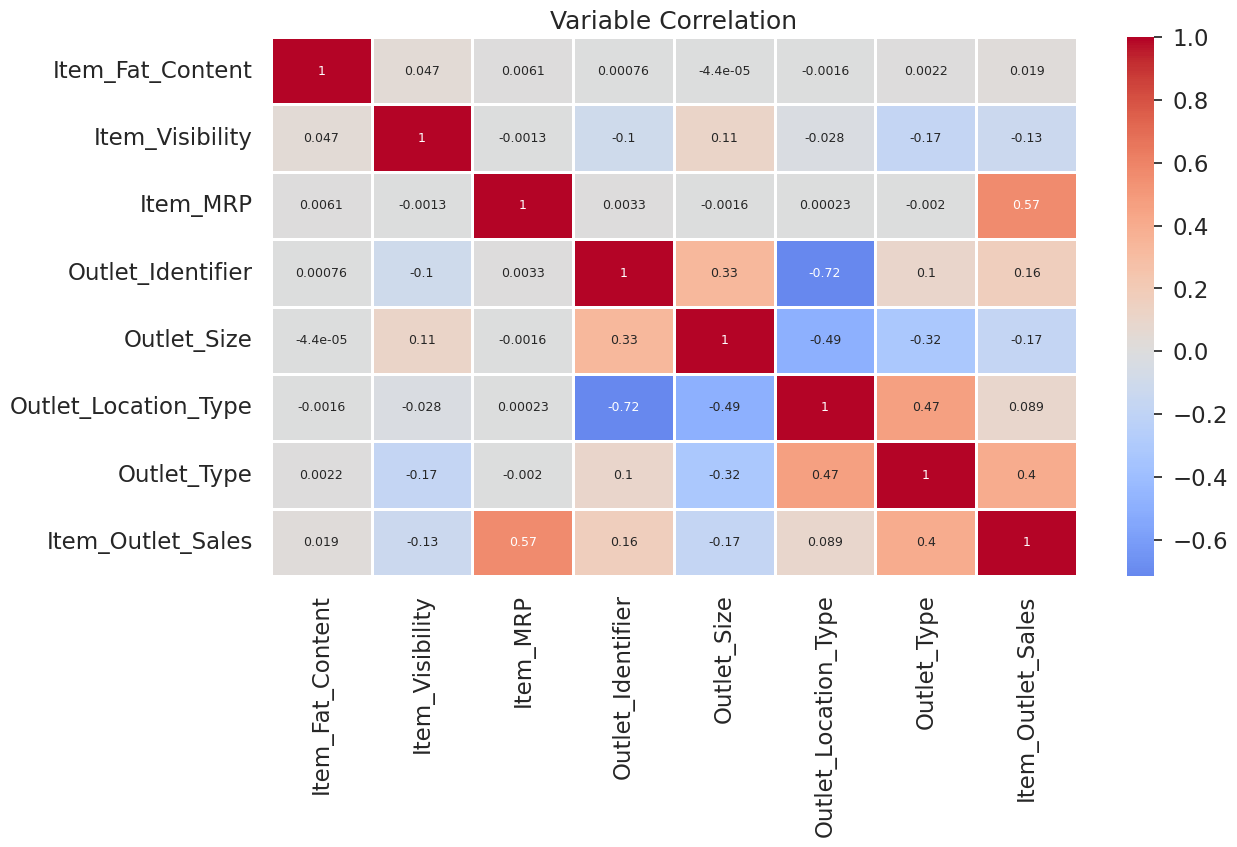

In [16]:
from IPython.core.pylabtools import figsize
f,ax=plt.subplots(figsize=(13,7))

sns.heatmap(data.corr(),center=0, linewidths=0.9,cmap='coolwarm',annot=True, annot_kws={"size": 9})
plt.title('Variable Correlation')

In [17]:
#Computing Linear Regression model for BigMart dataset
def linear_reg(X_train,y_train,X_test,y_test):
    linear_reg = LinearRegression()
    linear_reg_model = linear_reg.fit(X_train,y_train)
    print('Train set')
    pred=linear_reg_model.predict(X_train)
    print('Linear Regression Mean Squared error :{}'.format(mean_squared_error(y_train,pred)))
    print('Linear Regression r2_score :{}'.format(r2_score(y_train,pred)))
    print('Test set')
    pred=linear_reg_model.predict(X_test)
    model_lr=linear_reg_model.predict(X_test)
    print('Linear Regression Mean Squared error :{}'.format(mean_squared_error(y_test,pred)))
    print('Linear Regression r2_score :{}'.format(r2_score(y_test,pred)))

In [18]:
from sklearn import linear_model

model = linear_model.LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [19]:
cols1= ['Item_Fat_Content', 'Item_Visibility','Item_MRP', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type','Outlet_Type']

In [20]:
#Computing R2 for testing and training data
linear_reg(X_train[cols1],y_train,X_test[cols1],y_test)

Train set
Linear Regression Mean Squared error :0.008551710725409608
Linear Regression r2_score :0.5073788714985458
Test set
Linear Regression Mean Squared error :0.007533446960229273
Linear Regression r2_score :0.5277035908090755


# SHAP Analysis on Linear Regression model

SHAP values for each feature represent the change in the expected model prediction when conditioning on that feature. For each feature, SHAP value explains the contribution to explain the difference between the average model prediction and the actual prediction of the instance.The essence of Shapley value is to measure the contributions to the final outcome from each player separately among the coalition, while preserving the sum of contributions being equal to the final outcome.SHAP values in model explanation can measure the input features contribution to individual predictions.

In [21]:
%%capture
!pip install shap
import shap

In [22]:
import shap
shap.initjs()

In [23]:
# Giving input as 1% of whole dataset as SHAP cant handle large dataset
X = X_train.sample(frac=0.01,random_state=200)
#LinearExplainer is used as linear regression model is used
explainer = shap.LinearExplainer(model, X, feature_perturbation="interventional")
shap_values = explainer.shap_values(X) #Saving SHAP values

In [24]:
#Initialize java script
shap.initjs()

 #Explain one row in the data with the
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:])

In [25]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X)

In [26]:
#Initializing explainer from shap, lm is our trained model
explainer_shap=shap.LinearExplainer(model=model, masker=X_train)

#Computing shap values for train dataset
shap_values = explainer_shap.shap_values(X_train)

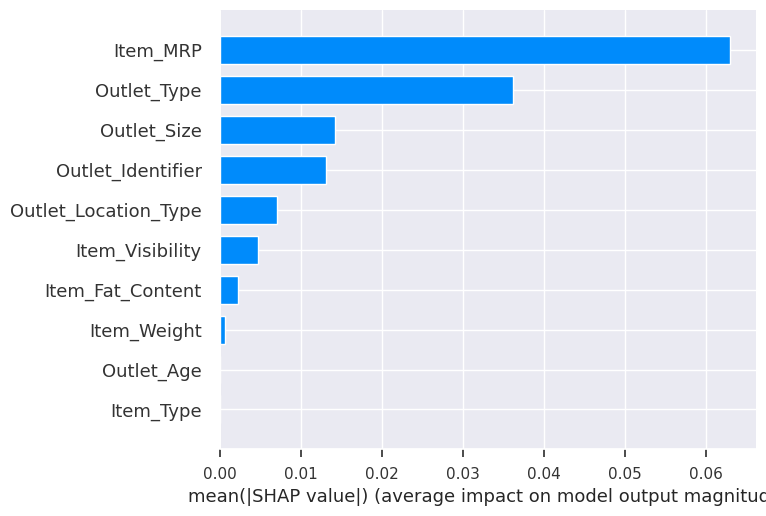

In [27]:
shap.summary_plot(shap_values, X, plot_type="bar")

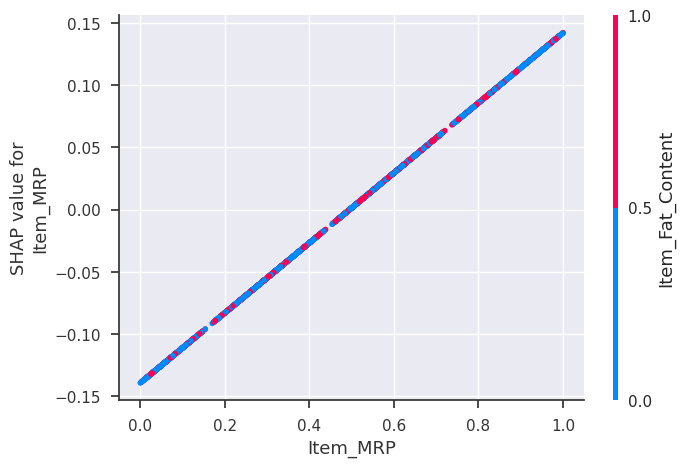

In [28]:
shap.dependence_plot("Item_MRP", shap_values, X_train)

In [29]:
from sklearn.linear_model import LinearRegression
import shap

# train Linear model
#Seperating the dependent and independent variable from the main dataset
X=data.drop(['Item_Outlet_Sales'],axis=1)
y=data['Item_Outlet_Sales']
regressor = LinearRegression()
linear_reg = regressor.fit(X, y)

# compute SHAP values
explainer = shap.Explainer(linear_reg, X)
shap_values = explainer(X)

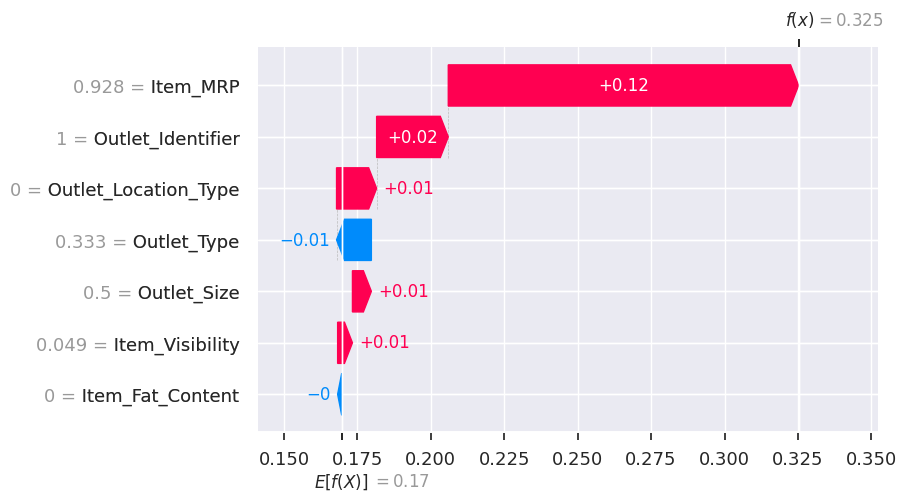

In [31]:
shap.plots.waterfall(shap_values[0])

For the linear regression model from the plots it can be interpreted that Item_MRP, Outlet_Type, Outlet_Size are the important features for this regressor model. These are the major features in determining the Item_Outlet_Sales of the BigMarket.

# Performing Random Forest


In [32]:
def ramdomforest(X_train,y_train,X_test,y_test):
    rf = RandomForestRegressor()
    rf_model = rf.fit(X_train,y_train)
    print('Train set')
    pred=rf_model.predict(X_train)
    print('ramdomforest Mean Squared error :{}'.format(mean_squared_error(y_train,pred)))
    print('ramdomforest r2_score :{}'.format(r2_score(y_train,pred)))
    print('Tesst set')
    pred=rf_model.predict(X_test)
    print('ramdomforest Mean Squared error :{}'.format(mean_squared_error(y_test,pred)))
    print('ramdomforest r2_score :{}'.format(r2_score(y_test,pred)))

random_forest = RandomForestRegressor(n_estimators=100)
random_forest.fit(X_train, y_train)

RandomForestRegressor()

In [33]:
ramdomforest(X_train[cols1],y_train,X_test[cols1],y_test)

Train set
ramdomforest Mean Squared error :0.00110201888376882
ramdomforest r2_score :0.9365182238287058
Tesst set
ramdomforest Mean Squared error :0.006938918851533323
ramdomforest r2_score :0.5649765008570973


# SHAP Analysis on Random Forest Model

In [34]:
%%capture
!pip install shap
import shap

In [35]:
# Giving input as 1% of whole dataset as SHAP cant handle large dataset
X = X_train.head(10)
 # Using Tree explainer as this is tree based classifier model
explainer = shap.TreeExplainer(random_forest)
#Saving shap values
shap_values = explainer.shap_values(X)

In [36]:
shap.initjs() #Initialize java script
shap.force_plot(explainer.expected_value, shap_values[0,:], X.iloc[0,:]) #Explain one row in the data with the model

In [37]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X)

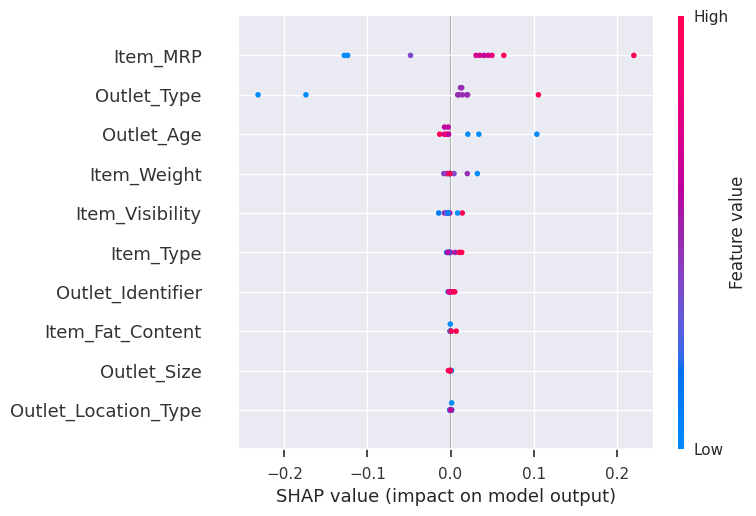

In [38]:
shap.initjs()
shap.summary_plot(shap_values, X)

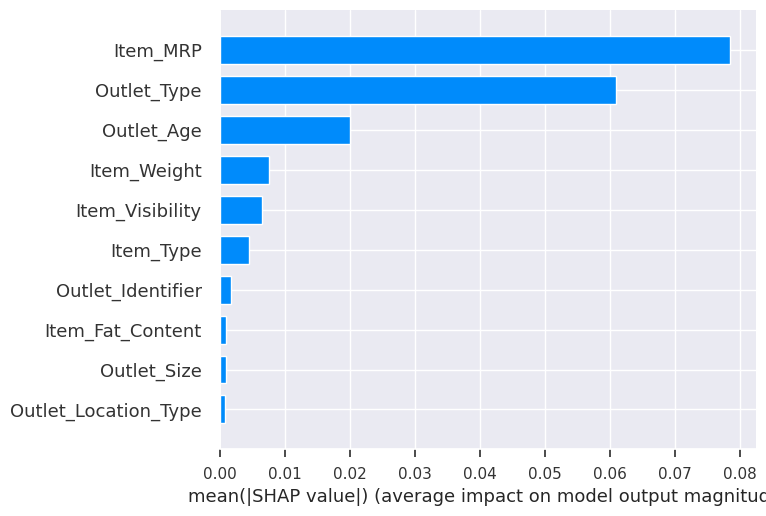

In [39]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [40]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_iris
iris = load_iris()

model_rf1 = RandomForestRegressor(n_estimators=10)
# Train
model_rf1.fit(iris.data, iris.target)
# Extract single tree
estimator = model_rf1.estimators_[5]

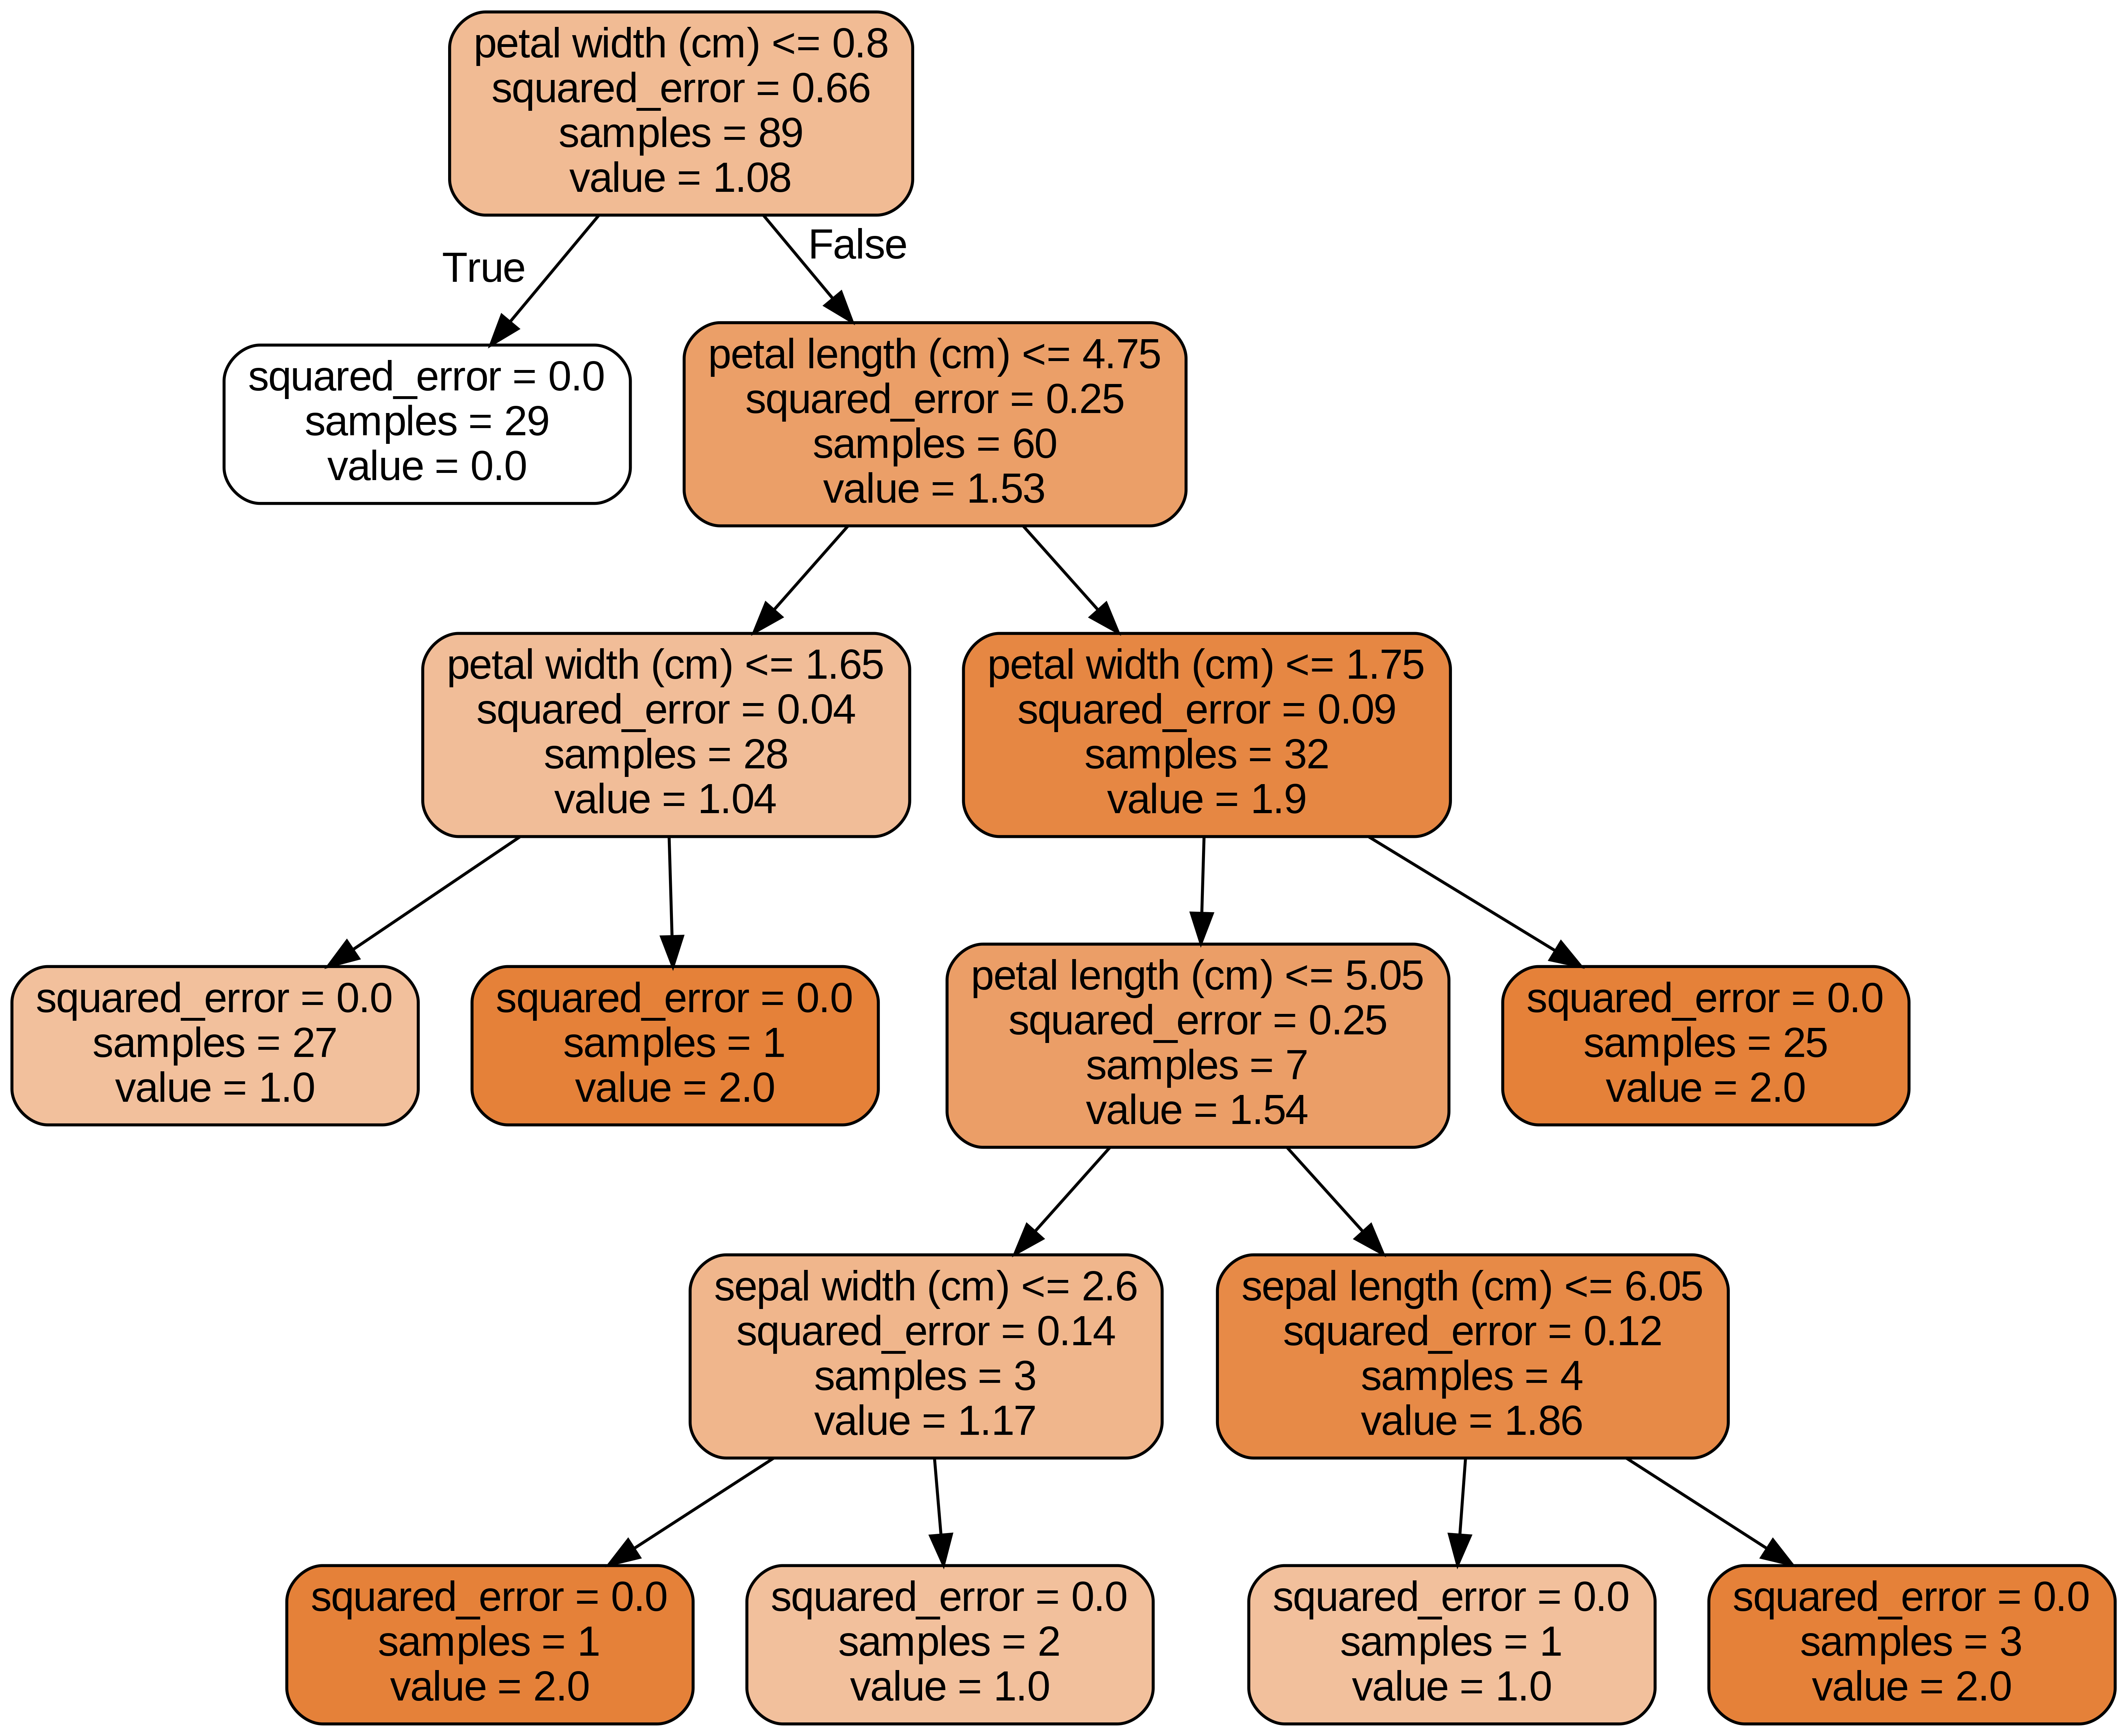

In [41]:
from sklearn.tree import export_graphviz
# Export as dot file
export_graphviz(estimator, out_file='tree.dot',
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                rounded = True, proportion = False,
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

# Display in colab notebook
from IPython.display import Image
Image(filename = 'tree.png')

For the random forest model according to SHAP Analysis the important features to determine the target variable 'Item_Outlet_Sales' are Item_MRP, Outlet_Type and Outlet_Age. Item_MRP and Outlet_Type are the common feature which is important for both Random Forest and Linear Regression Model. Item_MRP has the highest value of feature importance and is placed first on the scale.

# Using AutoML to identify best model


In [42]:
#importing all the necessary libraries

import h2o
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
import numpy as np
import scipy

In [43]:
# Set a minimum memory size and a run time in seconds
min_mem_size=6
run_time=222

In [44]:
# Use 50% of availible resources
pct_memory=0.5
virtual_memory=psutil.virtual_memory()
min_mem_size=int(round(int(pct_memory*virtual_memory.available)/1073741824,0))
print(min_mem_size)

5


In [45]:
# 65535 Highest port no
# Start the H2O server on a random port
port_no=random.randint(5555,55555)

#  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
try:
  h2o.init(strict_version_check=False,min_mem_size_GB=min_mem_size,port=port_no) # start h2o
except:
  logging.critical('h2o.init')
  h2o.download_all_logs(dirname=logs_path, filename=logfile)
  h2o.cluster().shutdown()
  sys.exit(2)


Checking whether there is an H2O instance running at http://localhost:11171..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.22" 2024-01-16; OpenJDK Runtime Environment (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1); OpenJDK 64-Bit Server VM (build 11.0.22+7-post-Ubuntu-0ubuntu222.04.1, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp6j1q77wk
  JVM stdout: /tmp/tmp6j1q77wk/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp6j1q77wk/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:11171
Connecting to H2O server at http://127.0.0.1:11171 ... successful.


--------------------------  -----------------------------------------------------------------------------------------
H2O_cluster_uptime:         04 secs
H2O_cluster_timezone:       Etc/UTC
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.44.0.3
H2O_cluster_version_age:    2 months and 22 days
H2O_cluster_name:           H2O_from_python_unknownUser_jjp0zo
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    5 Gb
H2O_cluster_total_cores:    2
H2O_cluster_allowed_cores:  2
H2O_cluster_status:         locked, healthy
H2O_connection_url:         http://127.0.0.1:11171
H2O_connection_proxy:       {"http": null, "https": null, "colab_language_server": "/usr/colab/bin/language_service"}
H2O_internal_security:      False
Python_version:             3.10.12 final
--------------------------  -----------------------------------------------------------------------------------------

In [46]:
# Create a 80/20 train/test split
url = "https://raw.githubusercontent.com/apoorv1811/DataScience/main/BigMart.csv"
df = h2o.import_file(path = url)
pct_rows=0.80
df_train, df_test = df.split_frame([pct_rows])

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [47]:
# Set the features and target
X=df.columns
print(X)

y ='Item_Outlet_Sales'
X.remove(y)
print(X)

['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type', 'Item_MRP', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Item_Outlet_Sales', 'Outlet_Age']
['Item_Weight', 'Item_Fat_Content', 'Item_Visibility', 'Item_Type', 'Item_MRP', 'Outlet_Identifier', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type', 'Outlet_Age']


In [48]:
aml = H2OAutoML(max_runtime_secs=run_time, seed=1)
# Passing the training and testing dataset through H20 AutomML
aml.train(x=X,y=y,training_frame=df_train)

AutoML progress: |███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OStackedEnsembleEstimator : Stacked Ensemble
Model Key: StackedEnsemble_BestOfFamily_4_AutoML_1_20240314_12230


Model Summary for Stacked Ensemble: 
key                                        value
-----------------------------------------  ----------------
Stacking strategy                          cross_validation
Number of base models (used / total)       4/6
# GBM base models (used / total)           1/1
# XGBoost base models (used / total)       1/1
# DeepLearning base models (used / total)  1/1
# DRF base models (used / total)           0/2
# GLM base models (used / total)           1/1
Metalearner algorithm                      GLM
Metalearner fold assignment scheme         Random
Metalearner nfolds                         5
Metalearner fold_column
Custom metalearner hyperparameters         None

ModelMetricsRegressionGLM: stackedensemble
** Reported on train data. **

MSE: 0.0061108341081358855
RMSE: 0.07817182425999719
MAE: 0.055156919007835065
RMSLE: 0.06240933444675231
Mean Residual Deviance: 0.0061108341081358855
R^2: 0.6384871560941809
Null degrees of freedom: 6806
Residual degrees of freedom: 6802
Null deviance: 115.06215747321468
Residual deviance: 41.59644777408097
AIC: -15370.560252085746

ModelMetricsRegressionGLM: stackedensemble
** Reported on cross-validation data. **

MSE: 0.006784702643941908
RMSE: 0.08236930644324929
MAE: 0.0577470381192904
RMSLE: 0.06559036262558543
Mean Residual Deviance: 0.006784702643941908
R^2: 0.5986215458539121
Null degrees of freedom: 6806
Residual degrees of freedom: 6803
Null deviance: 115.09515009732038
Residual deviance: 46.18347089731257
AIC: -14660.499125335957

Cross-Validation Metrics Summary: 
                        mean        sd           cv_1_valid    cv_2_valid    cv_3_valid    cv_4_valid    cv_5_valid
----------------------  ----------  -----------  ------------  ------------  ------------  ------------  ------------
mae                     0.0577224   0.00168249   0.0600682     0.057246      0.0586164     0.0556422     0.0570392
mean_residual_deviance  0.00678126  0.000421258  0.00738374    0.00659641    0.00692433    0.00624107    0.00676076
mse                     0.00678126  0.000421258  0.00738374    0.00659641    0.00692433    0.00624107    0.00676076
null_deviance           23.019      1.37456      25.3809       22.8529       22.7264       22.2338       21.9013
r2                      0.598811    0.0141337    0.588616      0.594867      0.583482      0.615827      0.611262
residual_deviance       9.23669     0.799373     10.4406       9.25477       9.46556       8.53779       8.48475
rmse                    0.0823168   0.00255251   0.0859287     0.0812183     0.0832126     0.0790005     0.0822238
rmsle                   0.0655429   0.00186953   0.0682084     0.0649095     0.0664566     0.0632635     0.0648767

[tips]
Use `model.explain()` to inspect the model.
--
Use `h2o.display.toggle_user_tips()` to switch on/off this section.

In [49]:
print(aml.leaderboard)

model_id                                                     rmse         mse        mae      rmsle    mean_residual_deviance
StackedEnsemble_BestOfFamily_4_AutoML_1_20240314_12230  0.0823693  0.0067847   0.057747   0.0655904                0.0067847
GBM_grid_1_AutoML_1_20240314_12230_model_2              0.0824925  0.00680501  0.0578929  0.0656322                0.00680501
StackedEnsemble_BestOfFamily_3_AutoML_1_20240314_12230  0.0825725  0.00681822  0.0580128  0.0657686                0.00681822
StackedEnsemble_AllModels_2_AutoML_1_20240314_12230     0.0826128  0.00682488  0.0580163  0.065794                 0.00682488
GBM_1_AutoML_1_20240314_12230                           0.0826699  0.00683431  0.0581175  0.0658034                0.00683431
StackedEnsemble_BestOfFamily_1_AutoML_1_20240314_12230  0.0826858  0.00683695  0.0581699  0.0658612                0.00683695
StackedEnsemble_AllModels_1_AutoML_1_20240314_12230     0.0827206  0.0068427   0.0581472  0.0658862                0.00

In [50]:
model_index=0
glm_index=0
glm_model=''
aml_leaderboard_df=aml.leaderboard.as_data_frame()
models_dict={}
for m in aml_leaderboard_df['model_id']:
  models_dict[m]=model_index
  if 'StackedEnsemble' not in m:
    break
  model_index=model_index+1

for m in aml_leaderboard_df['model_id']:
  if 'GLM' in m:
    models_dict[m]=glm_index
    break
  glm_index=glm_index+1
models_dict

Export File progress: |██████████████████████████████████████████████████████████| (done) 100%


{'StackedEnsemble_BestOfFamily_4_AutoML_1_20240314_12230': 0,
 'GBM_grid_1_AutoML_1_20240314_12230_model_2': 1,
 'GLM_1_AutoML_1_20240314_12230': 28}

In [51]:
print(model_index)
best_model = h2o.get_model(aml.leaderboard[model_index,'model_id'])

1


In [52]:
#Printing the best model
print("The best model is - " , best_model.algo)

The best model is -  gbm


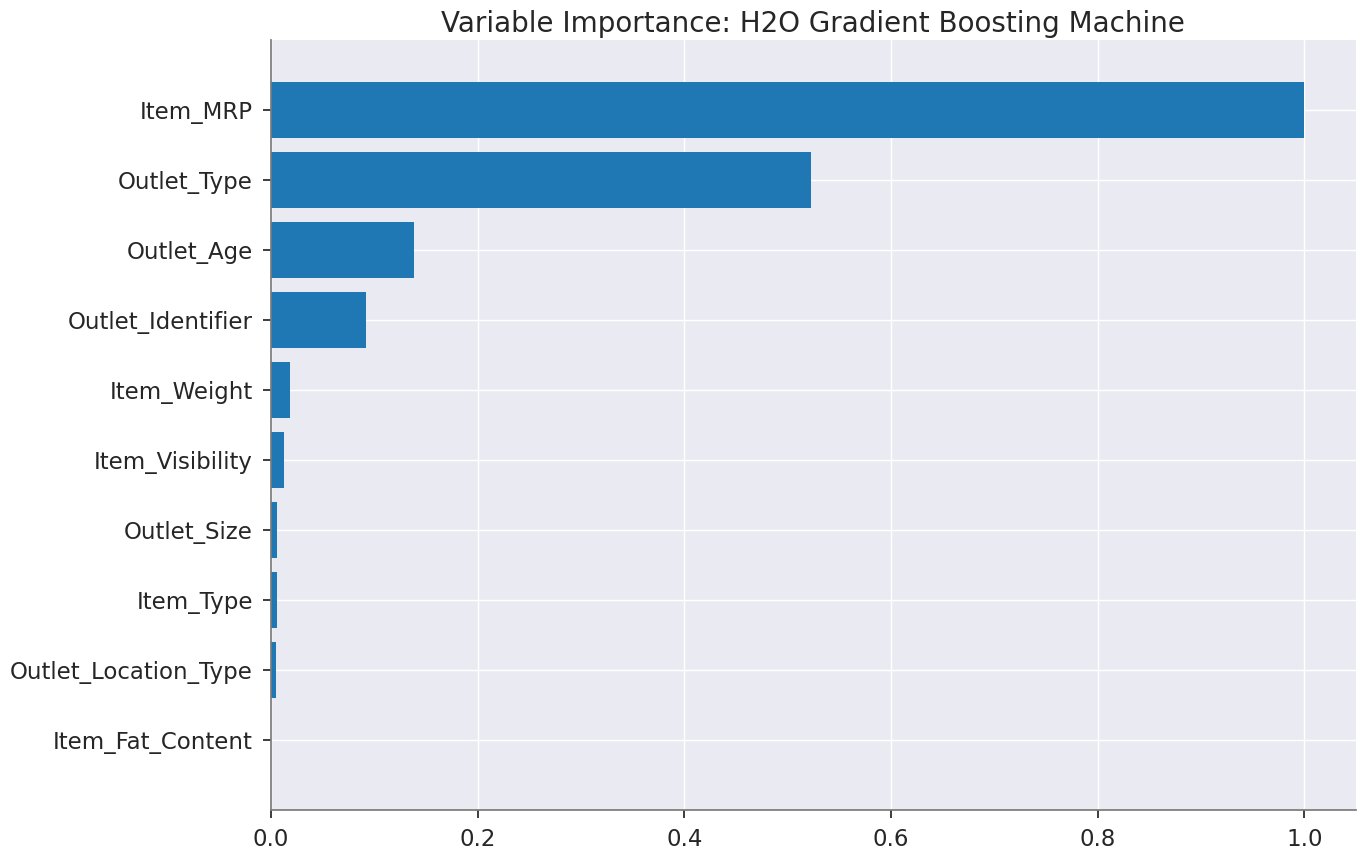

<Figure size 800x550 with 0 Axes>

In [53]:
#plot variables in order of their importance for price prediction
if best_model.algo in ['gbm','drf','xrt','xgboost']:
    best_model.varimp_plot()

28
glm


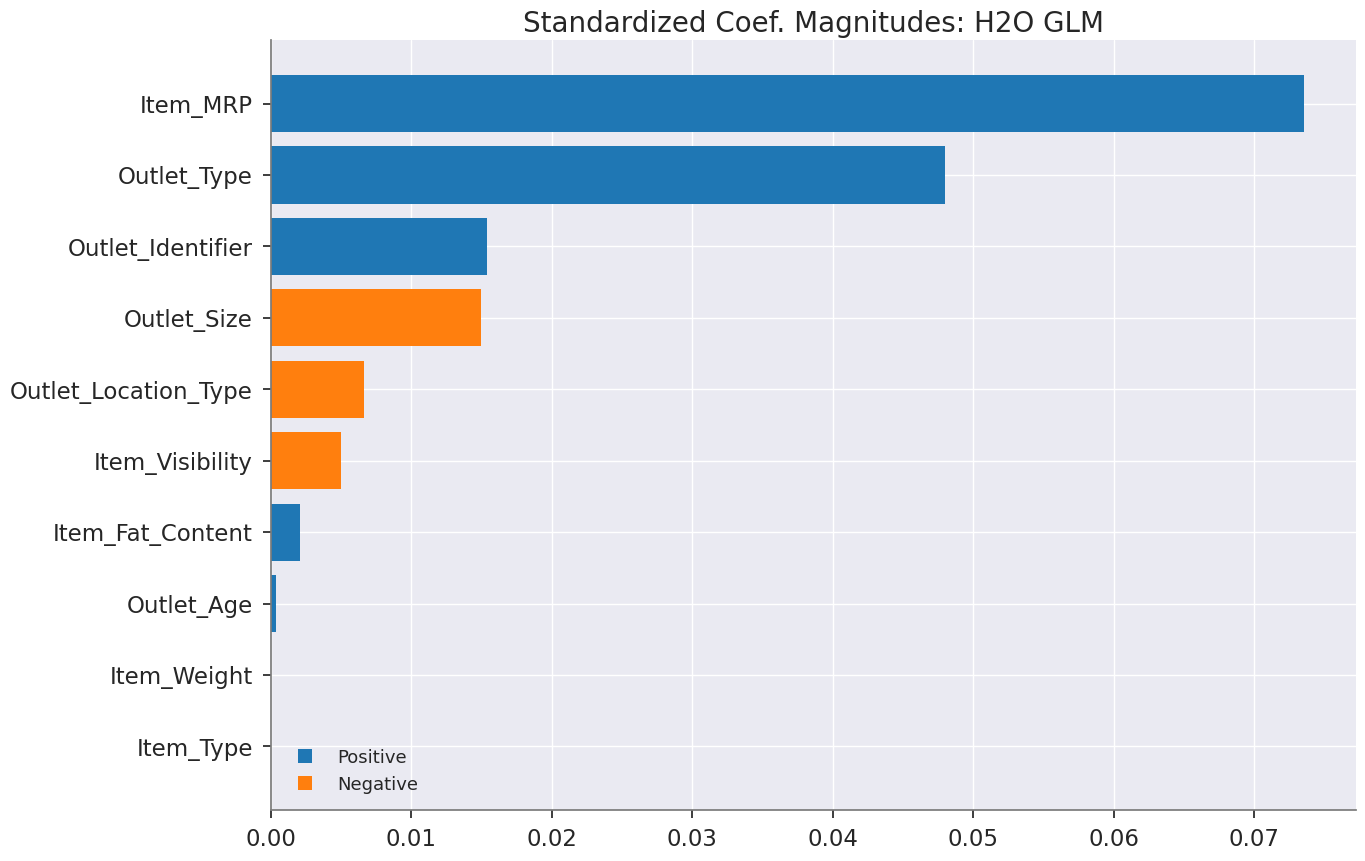

In [54]:
if glm_index is not 0:
  print(glm_index)
  glm_model=h2o.get_model(aml.leaderboard[glm_index,'model_id'])
  print(glm_model.algo)
  glm_model.std_coef_plot()

# SHAP Analysis on AutoML model

# Leaderboard

> Leaderboard shows models with their metrics. When provided with H2OAutoML object, the leaderboard shows 5-fold cross-validated metrics by default (depending on the H2OAutoML settings), otherwise it shows metrics computed on the frame. At most 20 models are shown by default.

model_id                                                     rmse         mse        mae      rmsle    mean_residual_deviance    training_time_ms    predict_time_per_row_ms  algo
------------------------------------------------------  ---------  ----------  ---------  ---------  ------------------------  ------------------  -------------------------  ---------------
StackedEnsemble_BestOfFamily_4_AutoML_1_20240314_12230  0.0825296  0.00681114  0.0576212  0.0657024                0.00681114                 553                   0.058052  StackedEnsemble
GBM_grid_1_AutoML_1_20240314_12230_model_2              0.0825888  0.00682091  0.0577016  0.0656867                0.00682091                 400                   0.010536  GBM
StackedEnsemble_BestOfFamily_3_AutoML_1_20240314_12230  0.0828531  0.00686464  0.0578664  0.06602                  0.00686464                 529                   0.078412  StackedEnsemble
StackedEnsemble_AllModels_2_AutoML_1_20240314_12230     0.0828737  0.00686804  0.0577777  0.0659958                0.00686804                 544                   0.064711  StackedEnsemble
DeepLearning_1_AutoML_1_20240314_12230                  0.0830638  0.0068996   0.0585431  0.0662625                0.0068996                  771                   0.004737  DeepLearning
StackedEnsemble_BestOfFamily_1_AutoML_1_20240314_12230  0.0831804  0.00691898  0.0580065  0.0662231                0.00691898                 488                   0.020269  StackedEnsemble
StackedEnsemble_BestOfFamily_2_AutoML_1_20240314_12230  0.0831833  0.00691946  0.0580139  0.0662234                0.00691946                 496                   0.057544  StackedEnsemble
StackedEnsemble_AllModels_1_AutoML_1_20240314_12230     0.0832272  0.00692676  0.0579626  0.0662383                0.00692676                 570                   0.061023  StackedEnsemble
GBM_1_AutoML_1_20240314_12230                           0.0833681  0.00695025  0.0581046  0.0663214                0.00695025                1847                   0.017965  GBM
GBM_grid_1_AutoML_1_20240314_12230_model_6              0.0835005  0.00697234  0.0592352  0.0665292                0.00697234                 495                   0.021152  GBM
GBM_grid_1_AutoML_1_20240314_12230_model_3              0.0837476  0.00701366  0.0587281  0.0666018                0.00701366                 748                   0.017909  GBM
GBM_5_AutoML_1_20240314_12230                           0.0839621  0.00704964  0.0583239  0.0665707                0.00704964                 404                   0.011677  GBM
DeepLearning_grid_1_AutoML_1_20240314_12230_model_1     0.0845887  0.00715525  0.0612581  0.0677514                0.00715525                1346                   0.007836  DeepLearning
GBM_3_AutoML_1_20240314_12230                           0.085157   0.00725172  0.0586425  0.0674289                0.00725172                 644                   0.015384  GBM
GBM_2_AutoML_1_20240314_12230                           0.0851877  0.00725695  0.0587719  0.0674948                0.00725695                 480                   0.02068   GBM
XGBoost_3_AutoML_1_20240314_12230                       0.085284   0.00727337  0.0592791  0.0678658                0.00727337                 868                   0.005751  XGBoost
XGBoost_grid_1_AutoML_1_20240314_12230_model_1          0.0853329  0.00728171  0.0598925  0.067905                 0.00728171                 992                   0.005443  XGBoost
GBM_grid_1_AutoML_1_20240314_12230_model_4              0.0855027  0.00731071  0.0605102  0.0680553                0.00731071                 965                   0.037594  GBM
XRT_1_AutoML_1_20240314_12230                           0.0860337  0.0074018   0.0598972  0.0684119                0.0074018                 3440                   0.032908  DRF
GBM_grid_1_AutoML_1_20240314_12230_model_5              0.0861008  0.00741336  0.0598665  0.0683442                0.00741336                 969      

# Residual Analysis

> Residual Analysis plots the fitted values vs residuals on a test dataset. Ideally, residuals should be randomly distributed. Patterns in this plot can indicate potential problems with the model selection, e.g., using simpler model than necessary, not accounting for heteroscedasticity, autocorrelation, etc. Note that if you see "striped" lines of residuals, that is an artifact of having an integer valued (vs a real valued) response variable.

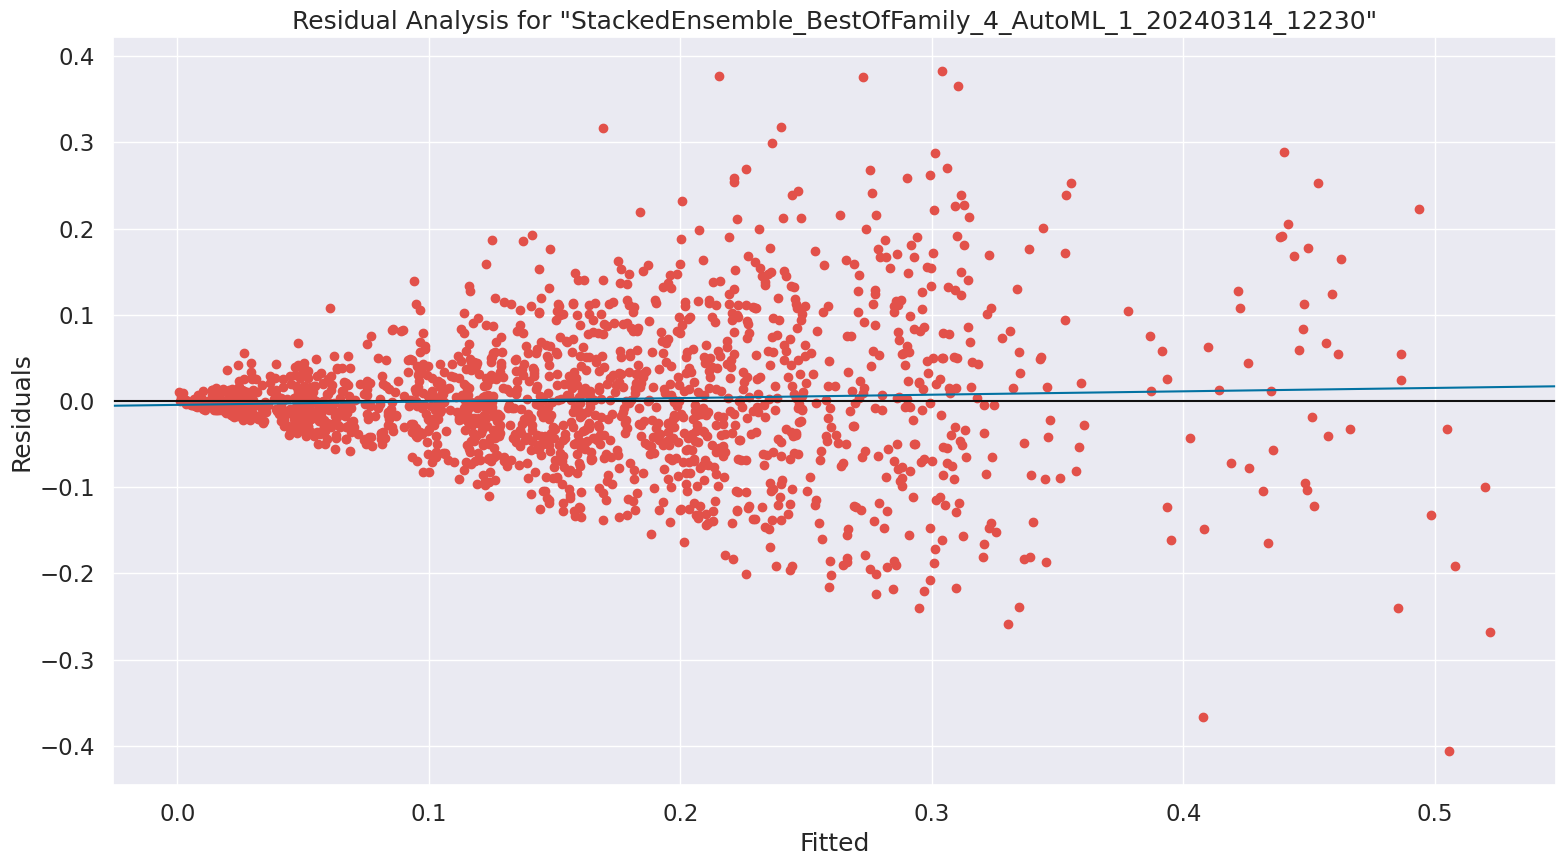

# Learning Curve Plot

> Learning curve plot shows the loss function/metric dependent on number of iterations or trees for tree-based algorithms. This plot can be useful for determining whether the model overfits.

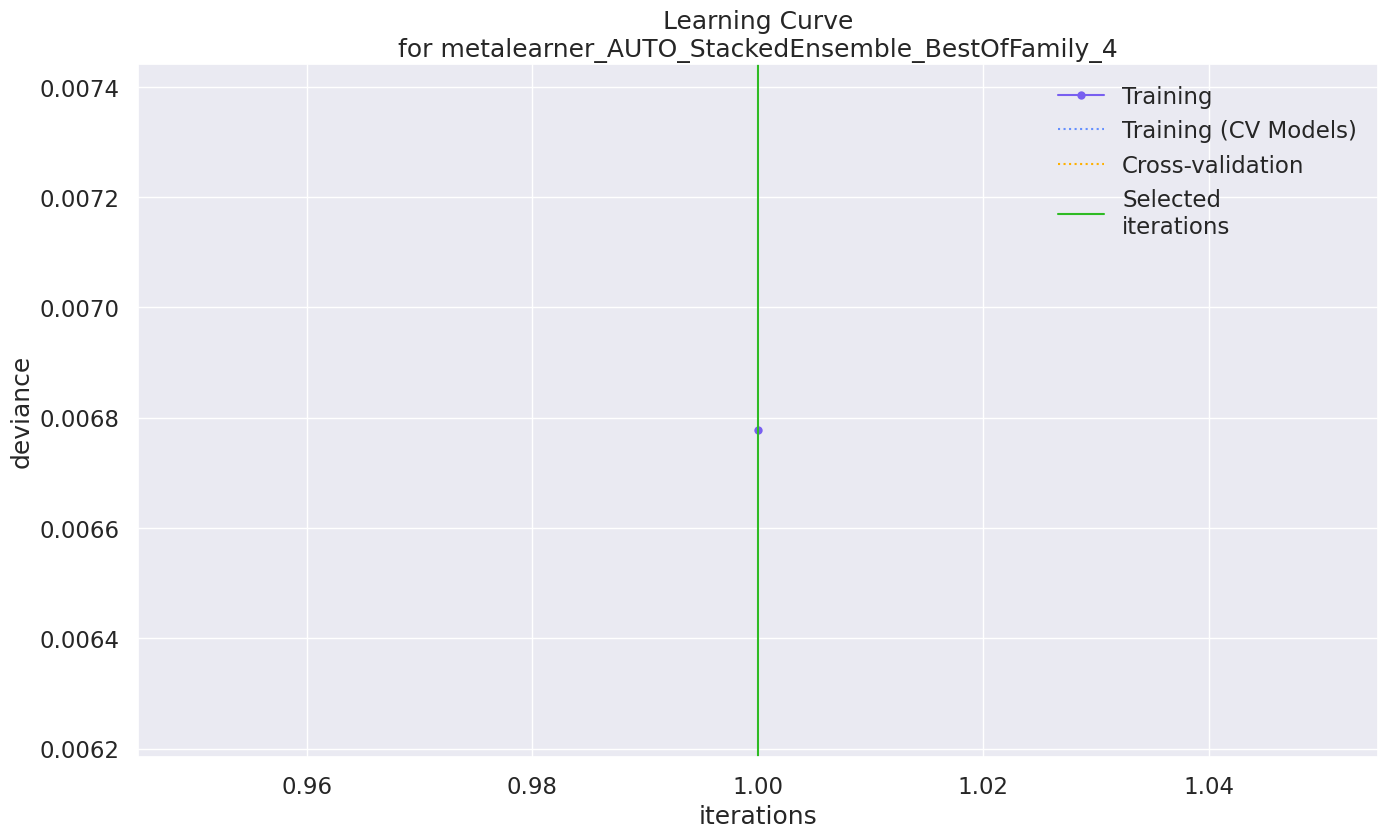

# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

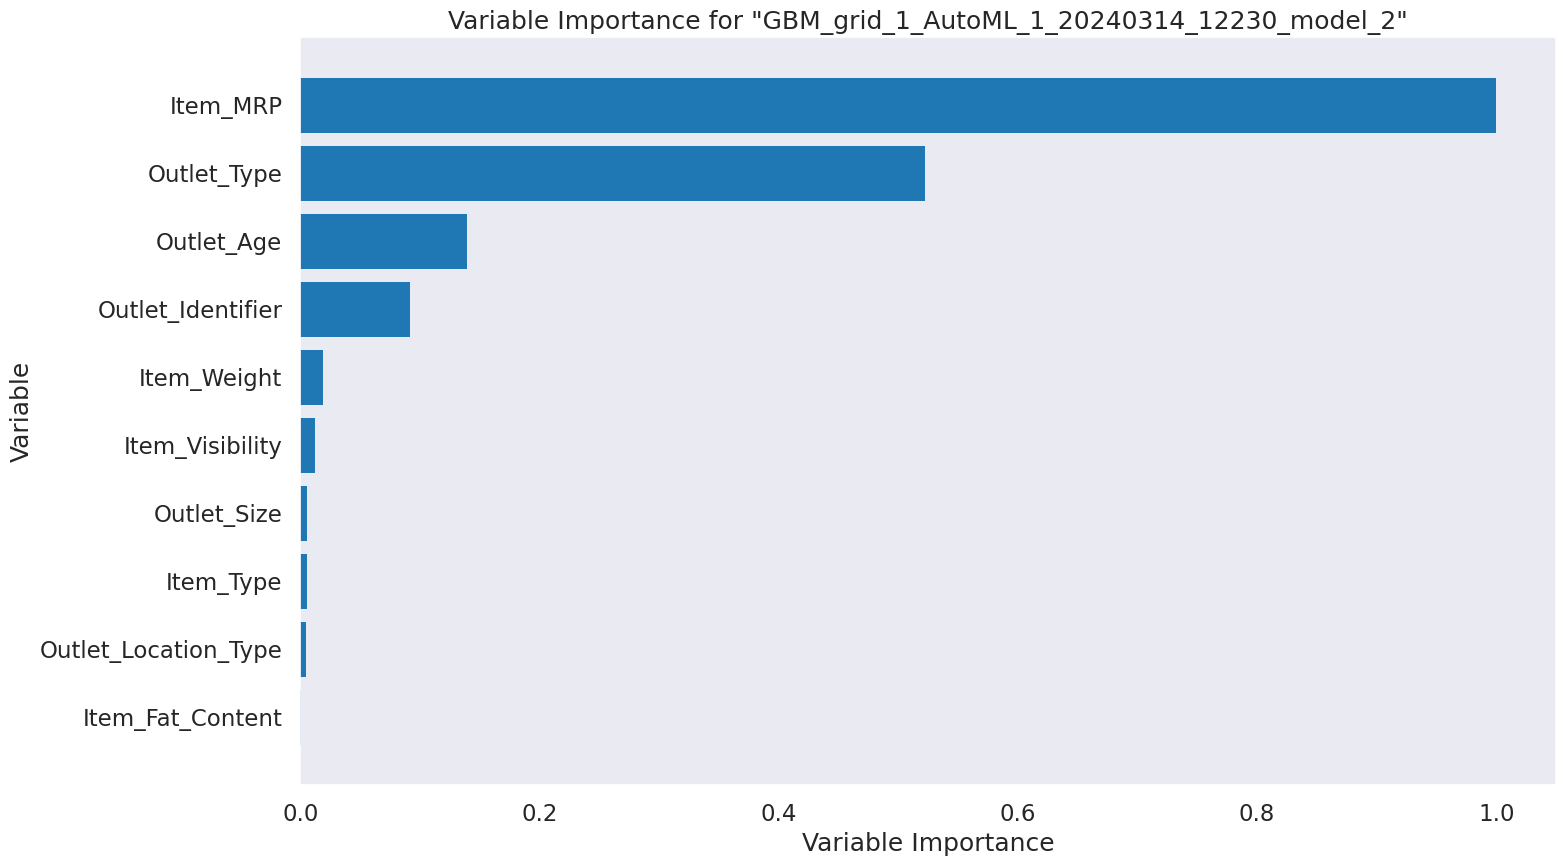

# Variable Importance Heatmap

> Variable importance heatmap shows variable importance across multiple models. Some models in H2O return variable importance for one-hot (binary indicator) encoded versions of categorical columns (e.g. Deep Learning, XGBoost). In order for the variable importance of categorical columns to be compared across all model types we compute a summarization of the the variable importance across all one-hot encoded features and return a single variable importance for the original categorical feature. By default, the models and variables are ordered by their similarity.

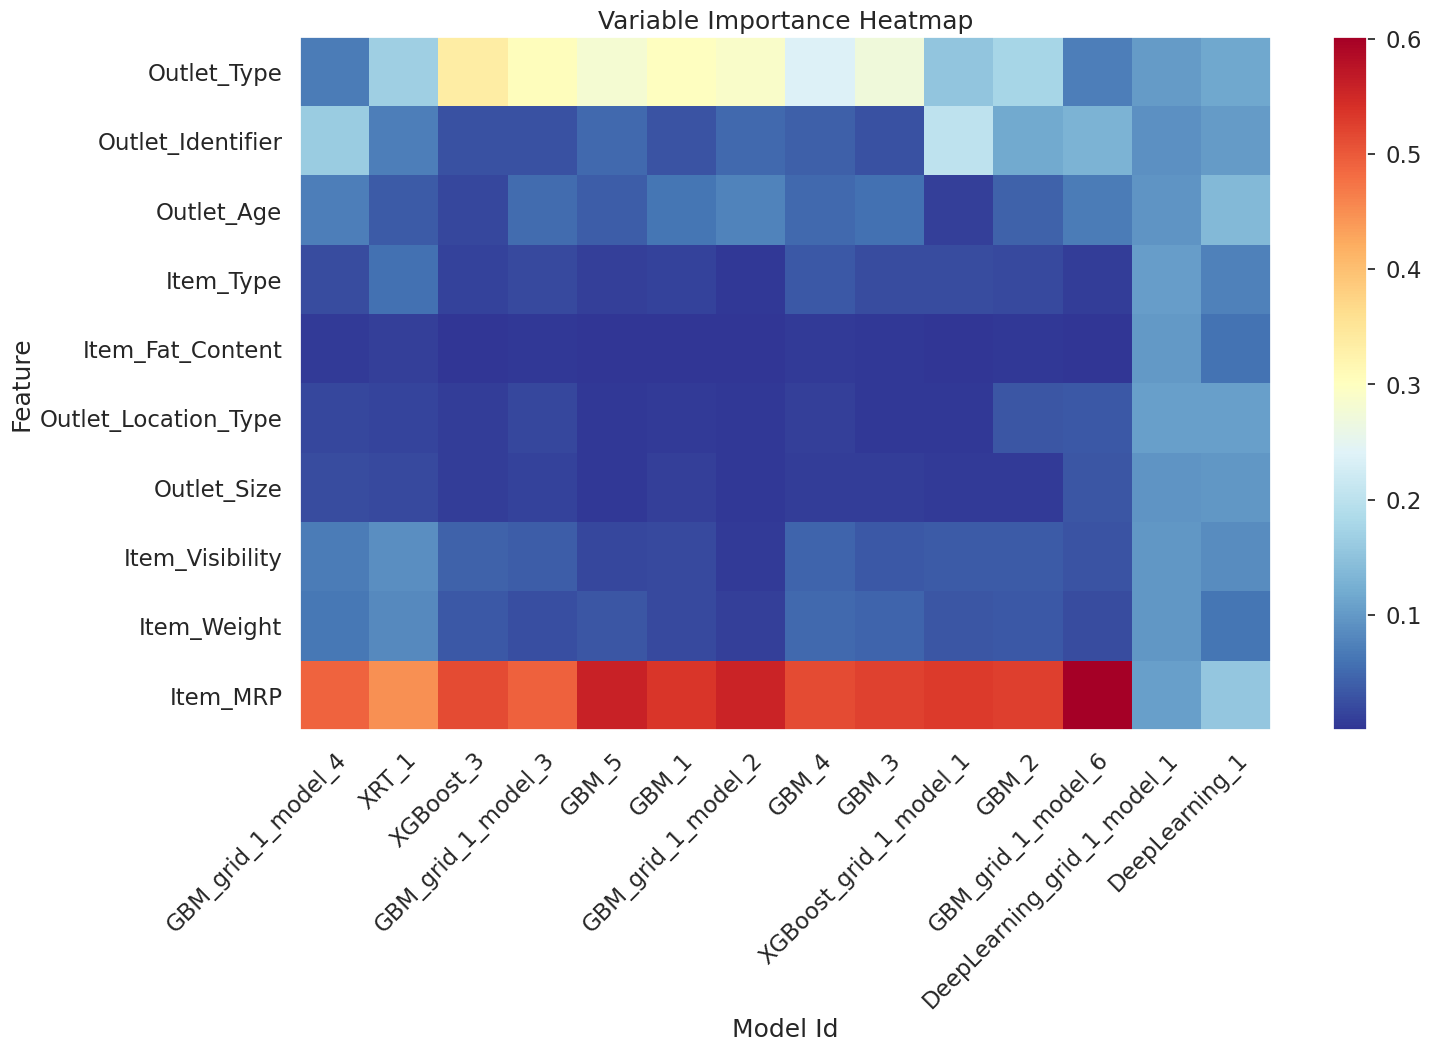

# Model Correlation

> This plot shows the correlation between the predictions of the models. For classification, frequency of identical predictions is used. By default, models are ordered by their similarity (as computed by hierarchical clustering). Interpretable models, such as GAM, GLM, and RuleFit are highlighted using red colored text.

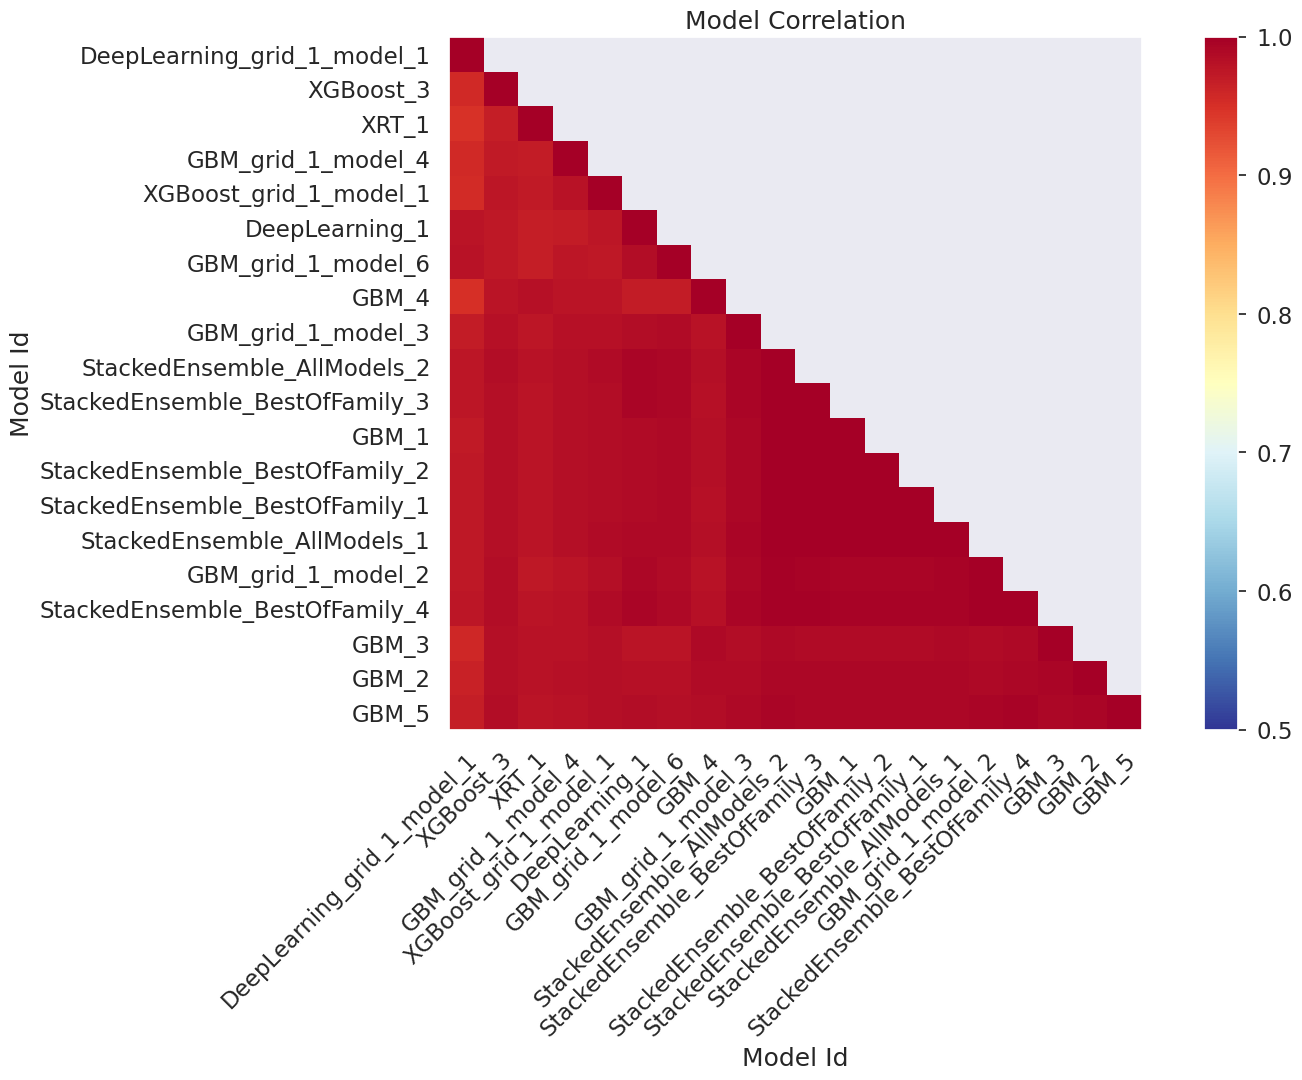

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

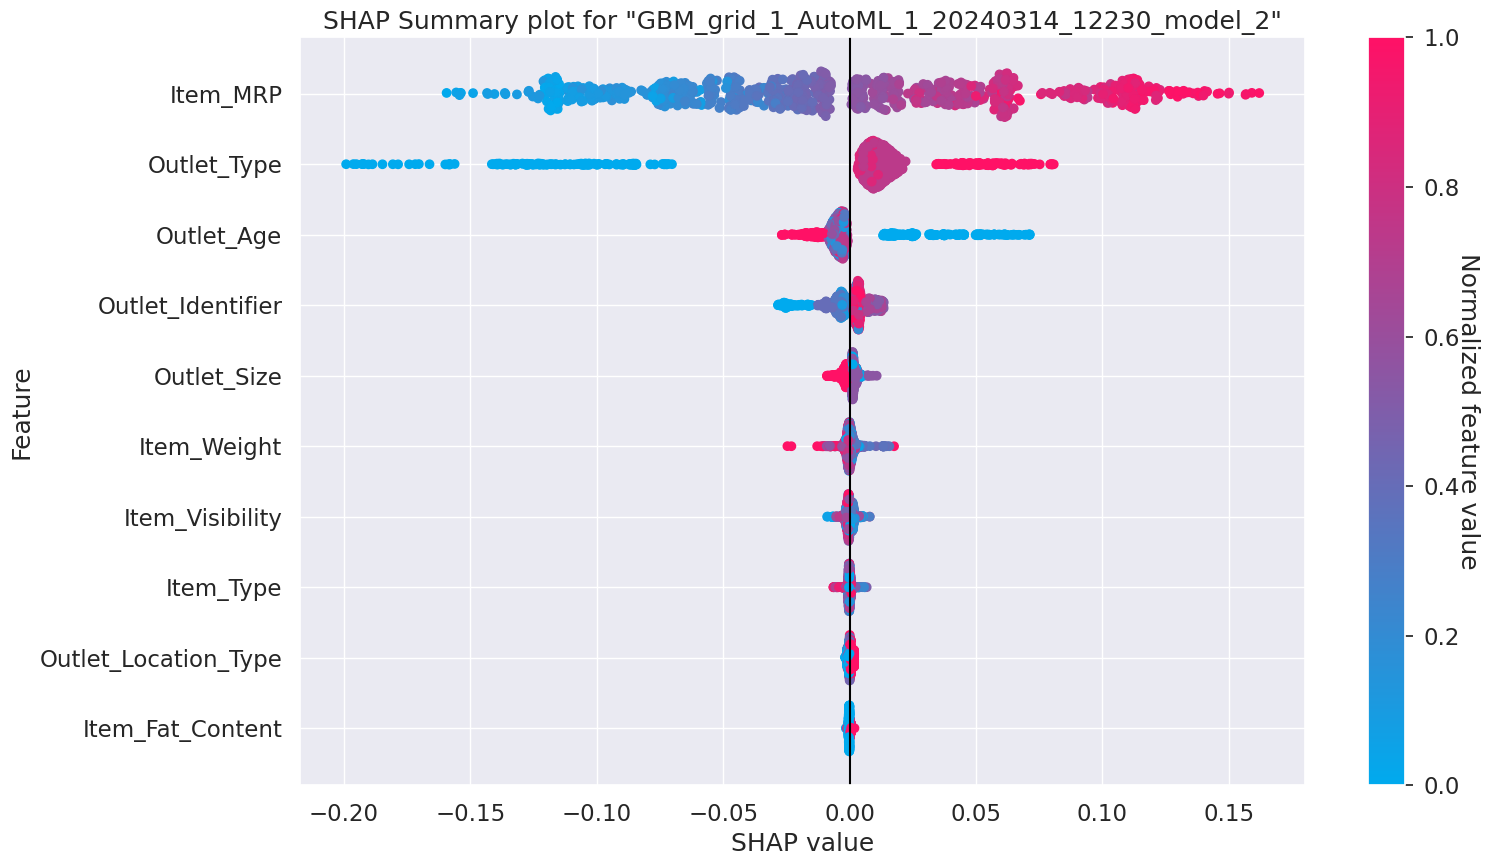

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

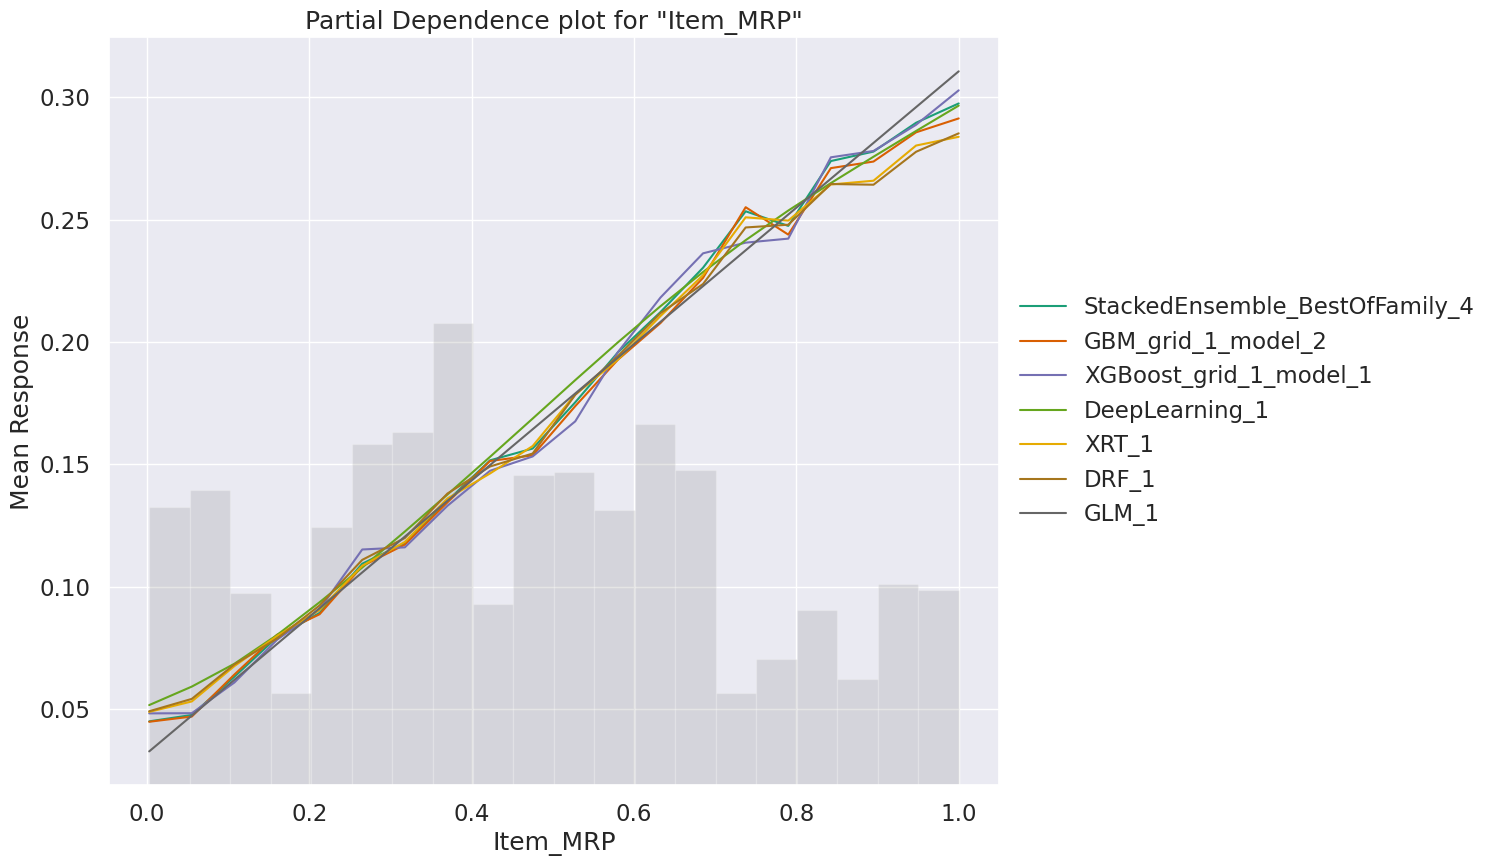

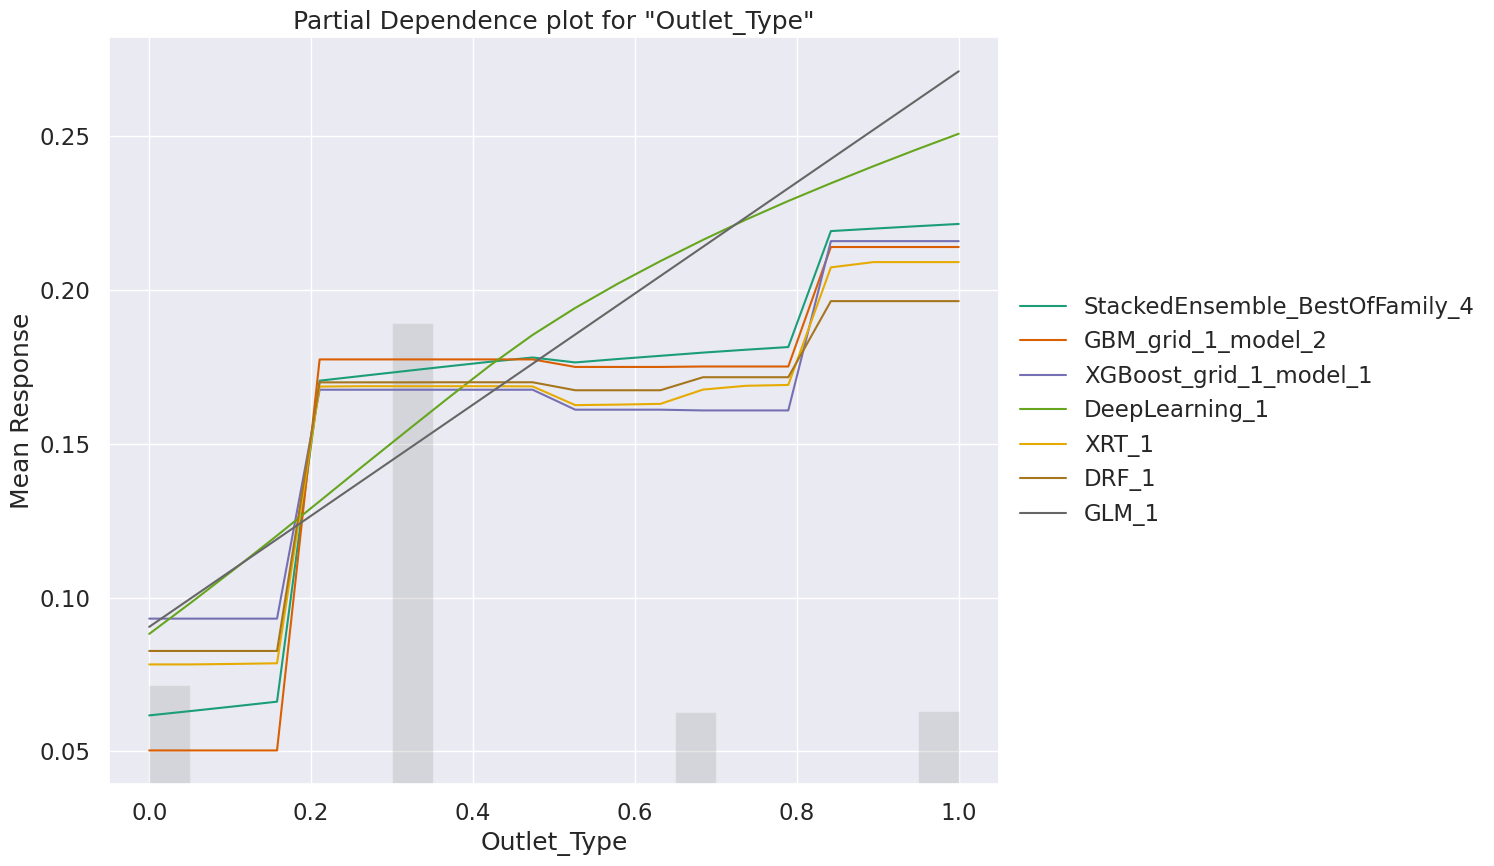

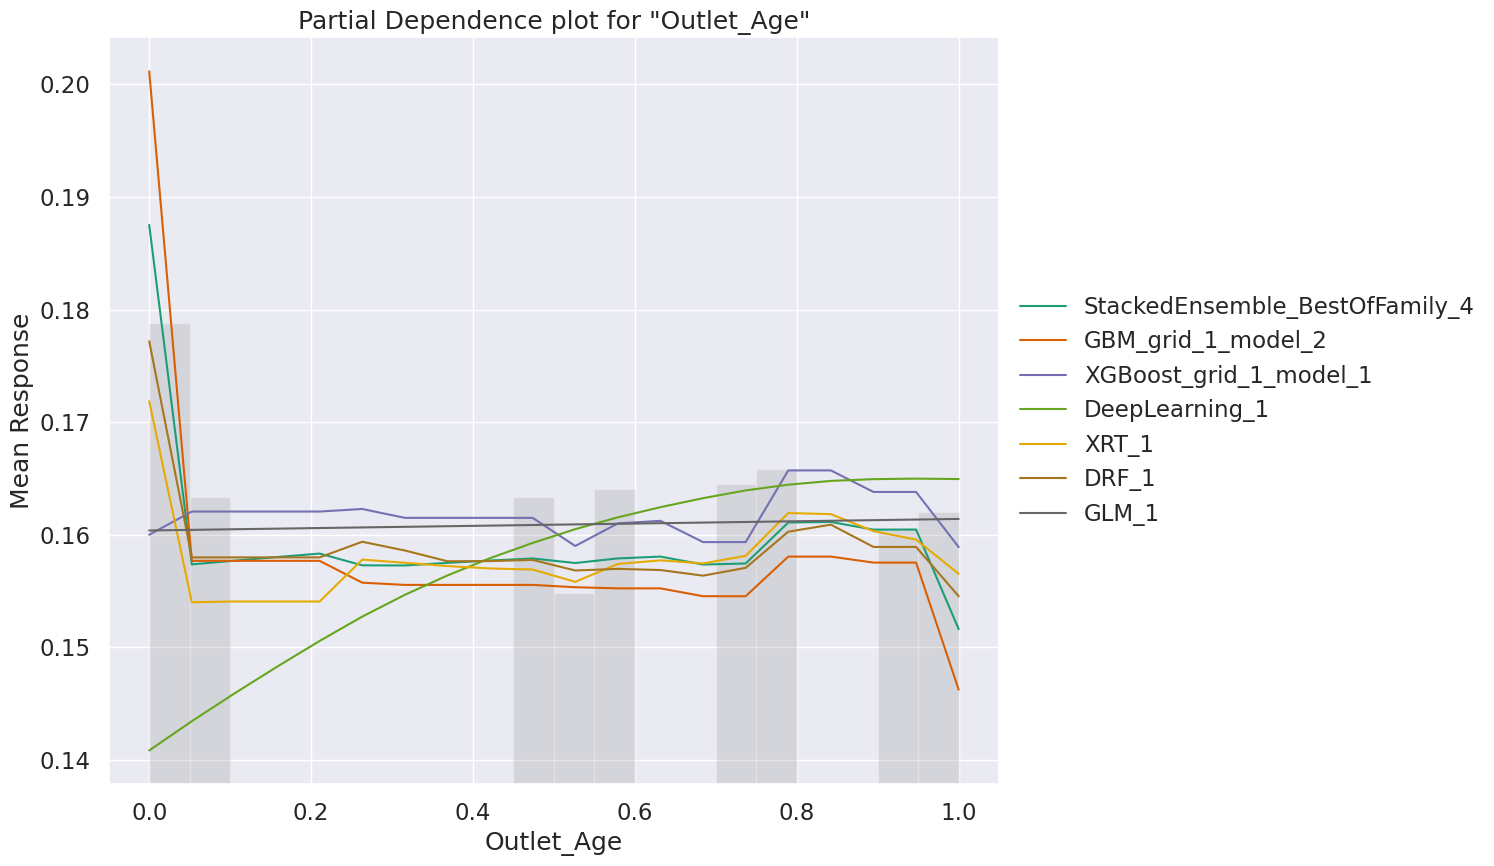

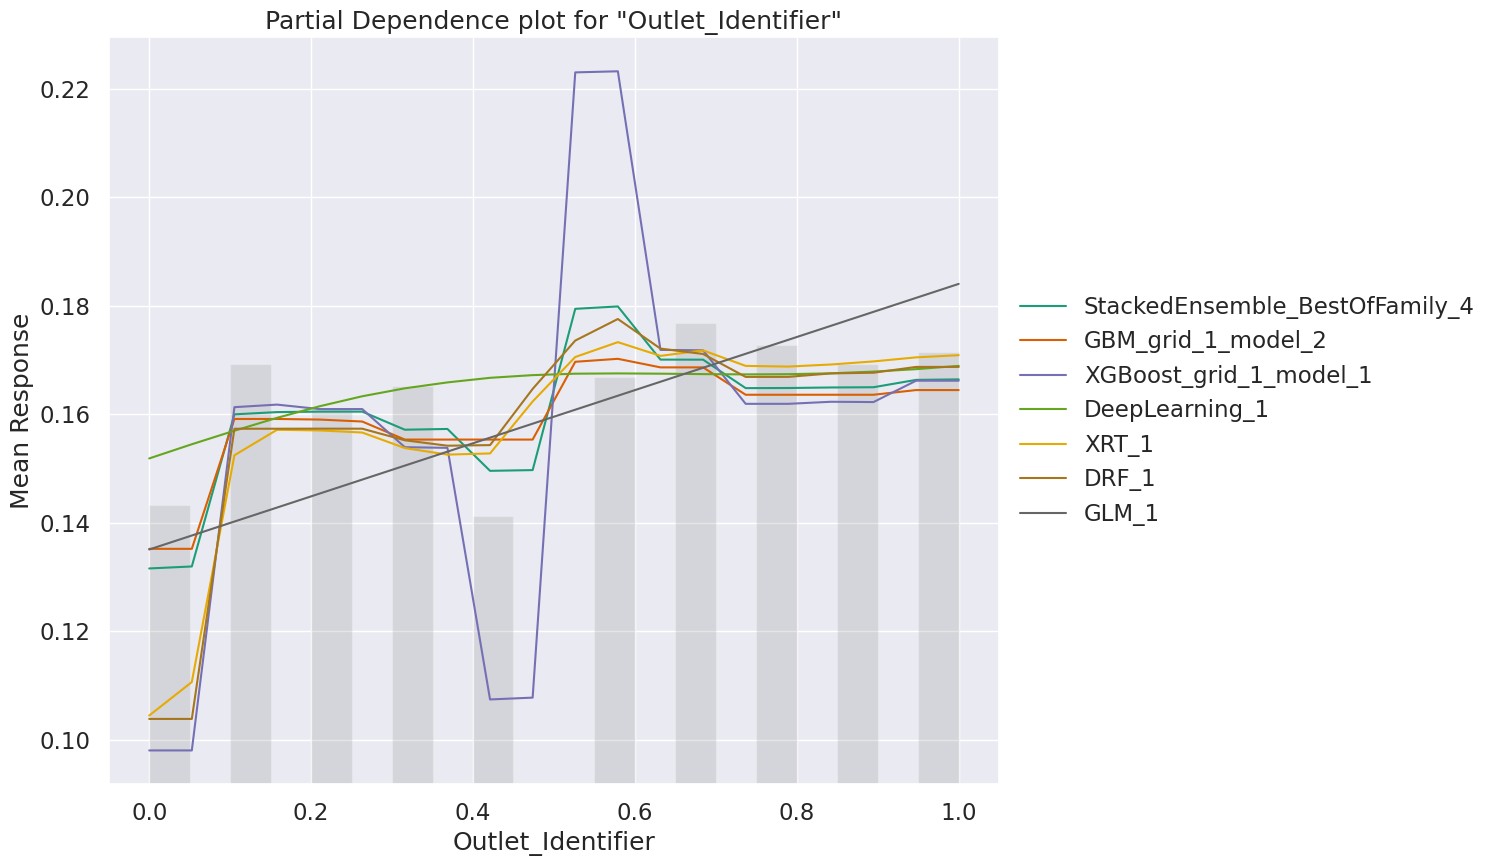

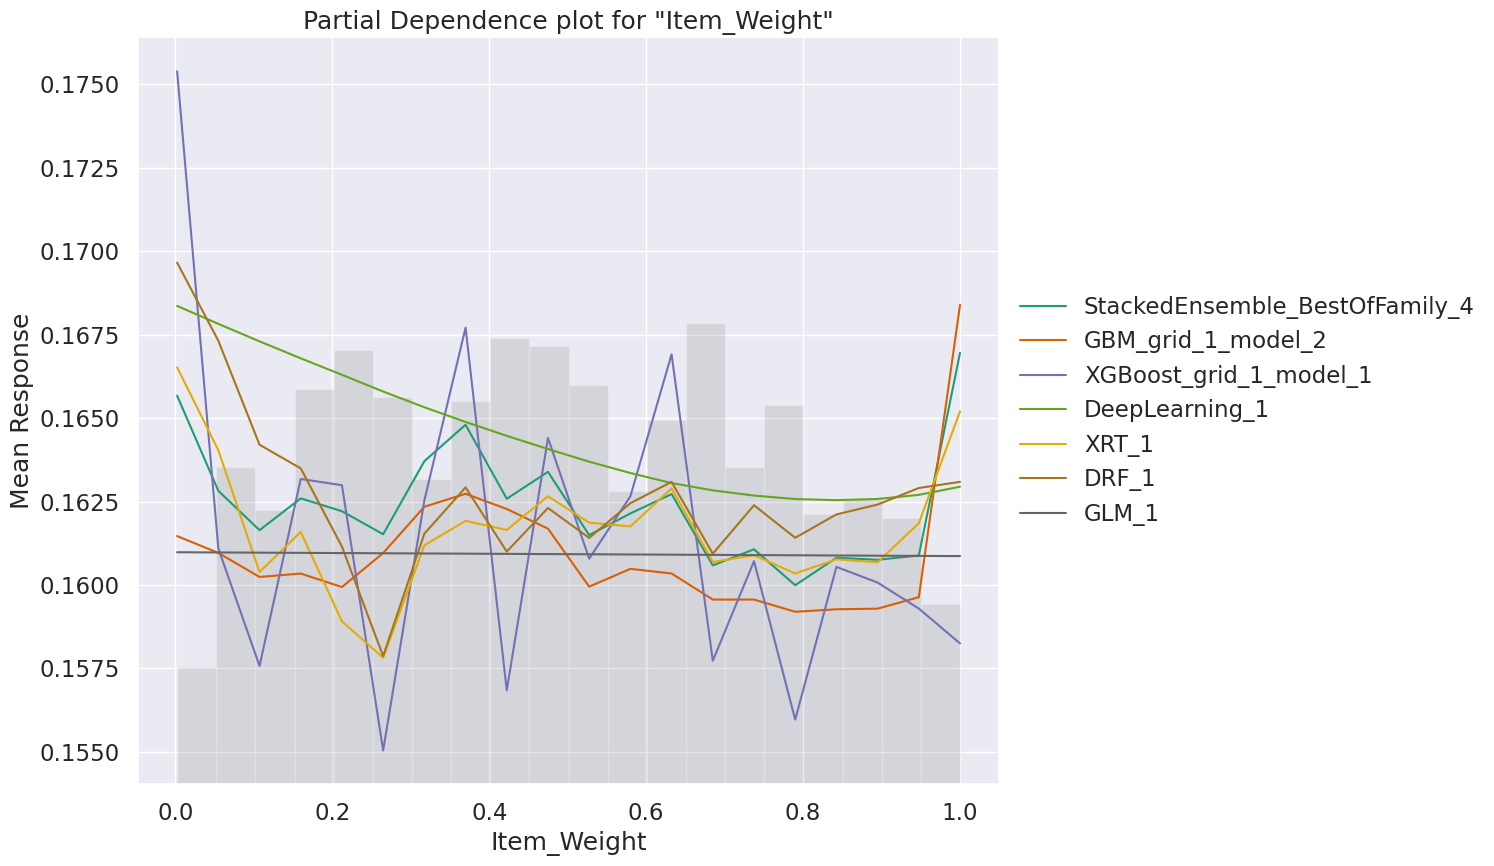

# Individual Conditional Expectation

> An Individual Conditional Expectation (ICE) plot gives a graphical depiction of the marginal effect of a variable on the response. ICE plots are similar to partial dependence plots (PDP); PDP shows the average effect of a feature while ICE plot shows the effect for a single instance. This function will plot the effect for each decile. In contrast to the PDP, ICE plots can provide more insight, especially when there is stronger feature interaction.

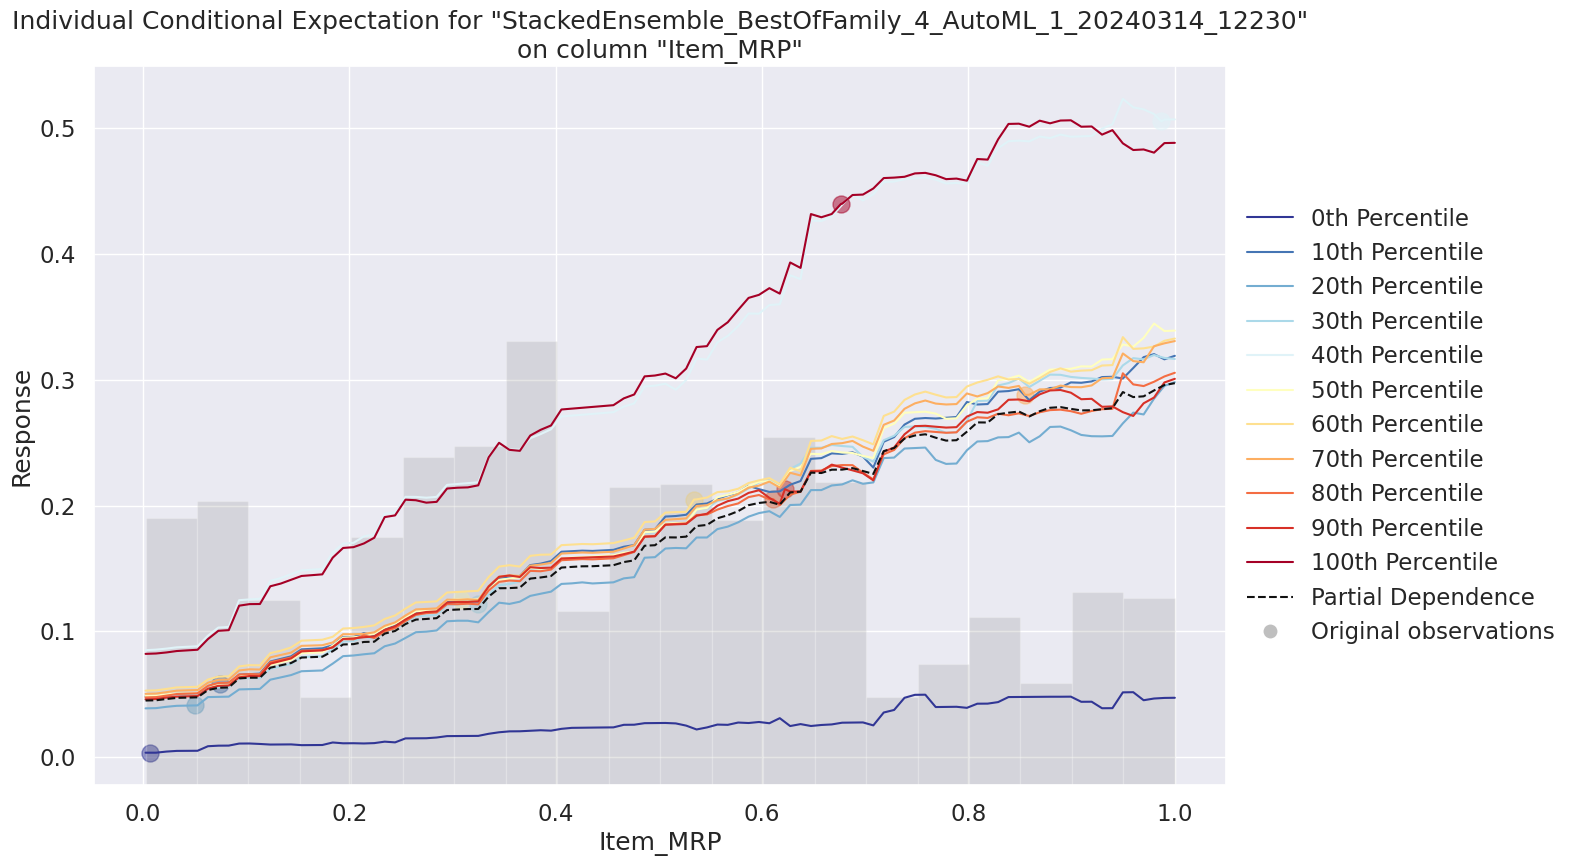

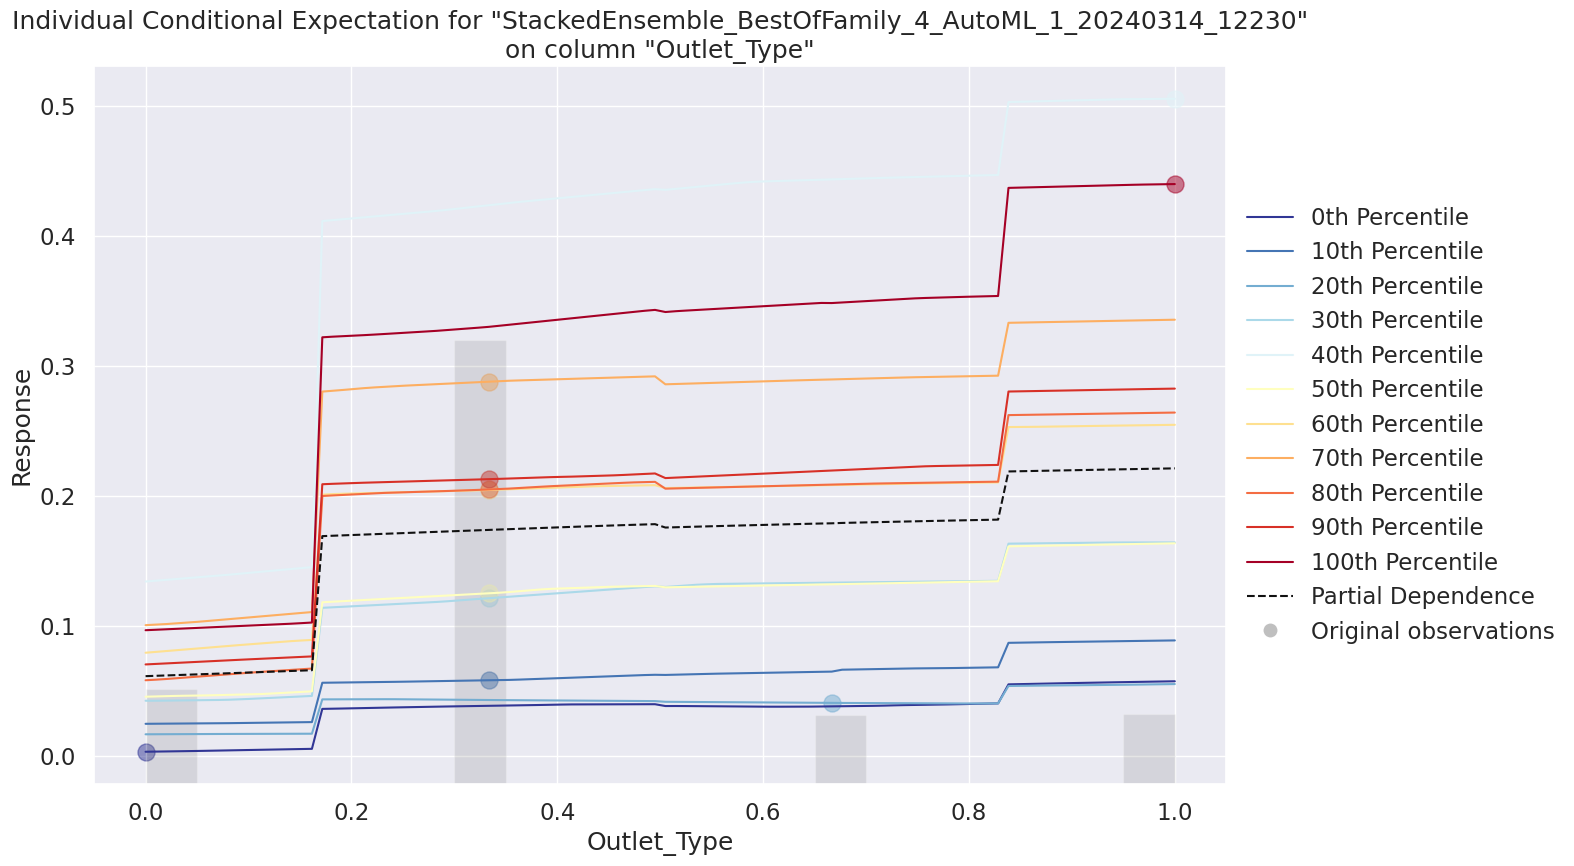

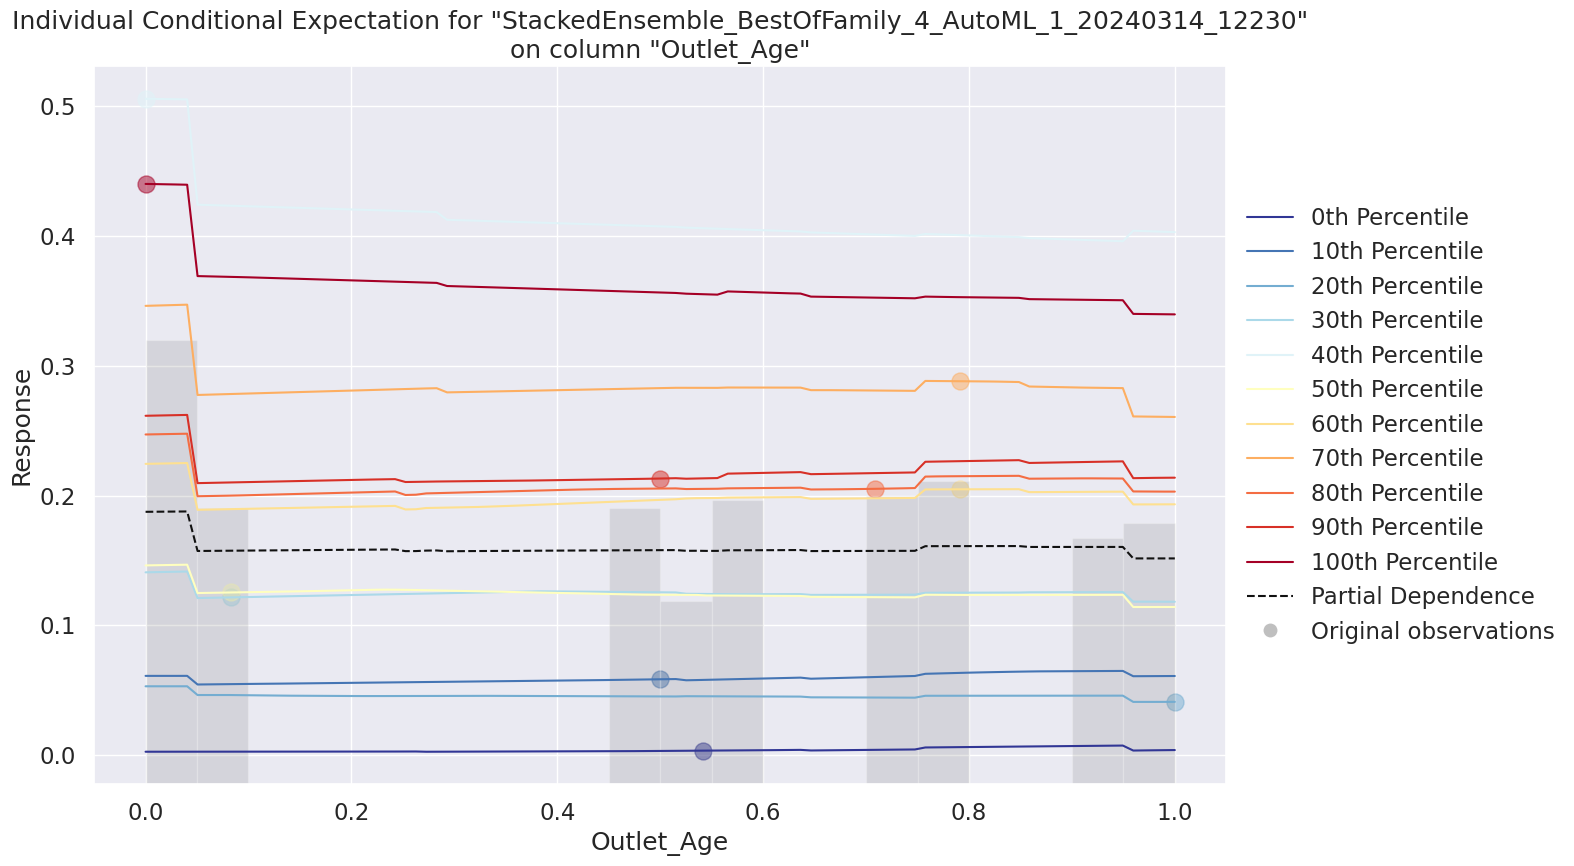

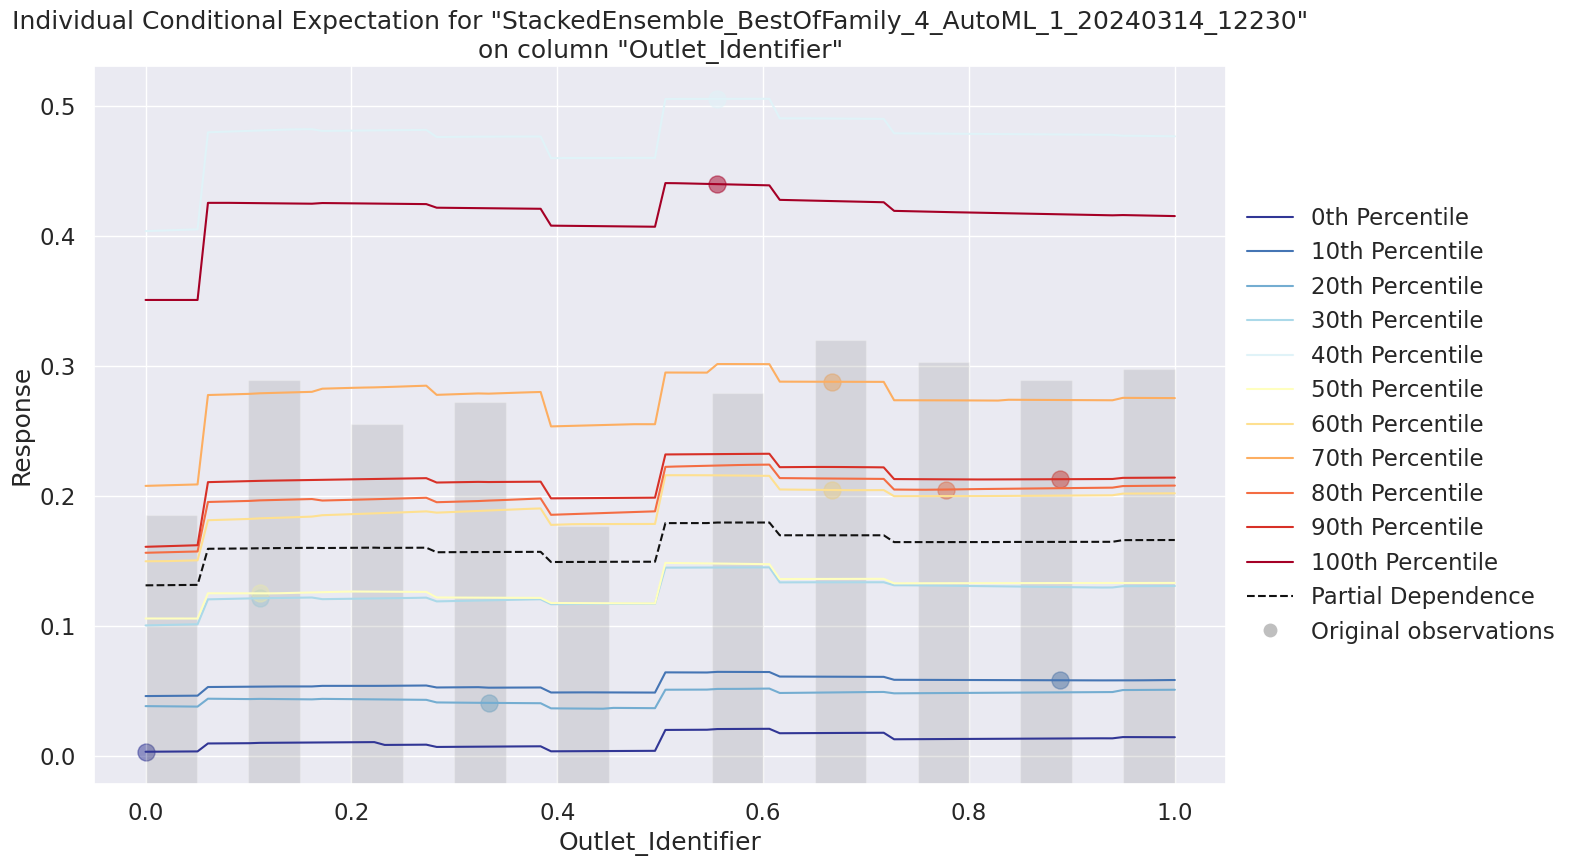

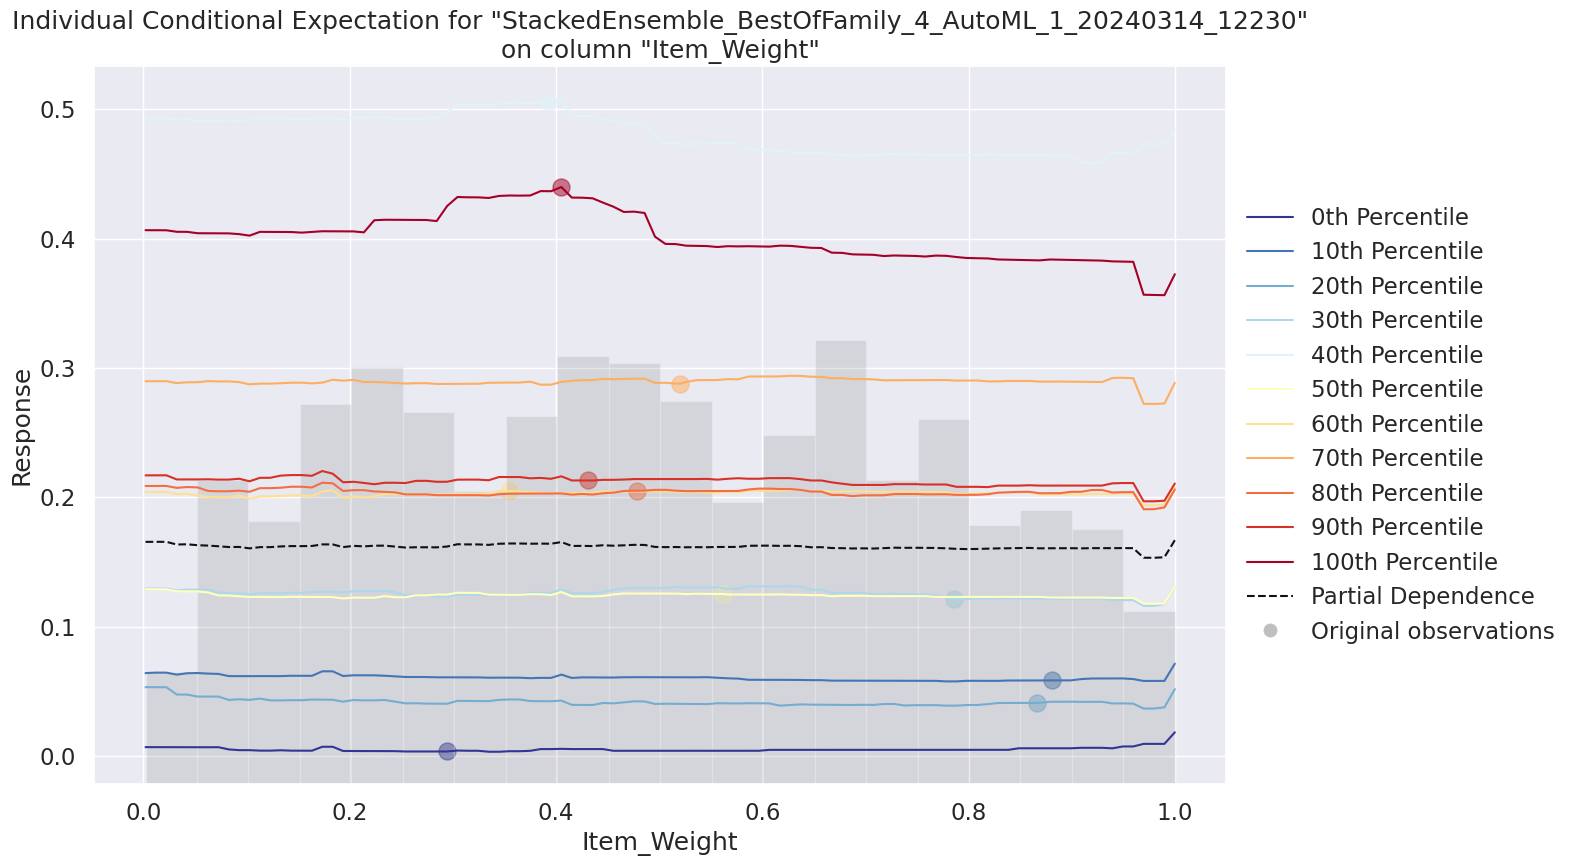

In [55]:
exa = aml.explain(df_test)

# CONCLUSION

For this dataset the best model according to AutoML is gbm. When a classifier like Random Forest was implemented on this dataset it gave a better accuracy. The accuracy on training data was 93.6 percent. On the other hand when Linear Regression was implemented the accuracy for training data was 51 percent. After implementing these model I calculated SHAP values using SHAP analysis method. I plotted different plots like permutation plots, waterfall plot, feature importance bar chart and many more plots.

For each model, the important feature obtained were different. Among all these 3 models the best accuracy was obtained for random forest model.The important features for this model were Item_MRP, Outlet_Type, Outlet_Size. This means that for this model the target variable 'Item_Outlet_Sales' is highly depended on Item_MRP, Outlet_Type, Outlet_Size.

# LICENSE

MIT License

Copyright (c) 2024 Apoorv Dhaygude

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

# REFERENCES

H20.ai- https://docs.h2o.ai/

OLS Model- http://net-informations.com/ds/mla/ols.html

Linear Regression- https://www.analyticsvidhya.com/blog/2021/05/all-you-need-to-know-about-your-first-machine-learning-model-linear-regression/

Linear Regression Assumptions- https://www.statisticssolutions.com/free-resources/directory-of-statistical-analyses/assumptions-of-linear-regression/

Kaggle Notebook- https://www.kaggle.com/code/ranasabrii/sales-prediction

Dataset- https://www.kaggle.com/datasets/brijbhushannanda1979/bigmart-sales-data

Random Forest Model- https://towardsdatascience.com/understanding-random-forest-58381e0602d2 and https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

SHAP Analysis- https://towardsdatascience.com/explain-your-model-with-the-shap-values-bc36aac4de3d and https://www.kaggle.com/code/dansbecker/shap-values/tutorial

Reference Notebook- https://github.com/ajhalthor/model-interpretability/blob/main/Shap%20Values.ipynb